# Description of Raw Data

This notebook is used to visualize the Raw Data from the Gesture Glove Experiments.

In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
# imports
from typing import Callable, List
import functools
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
from dataclasses import dataclass
from functools import reduce
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import tqdm
import random
import time
from datetime import datetime, timedelta
import gestureanalysis.read_raw as rr
import gestureanalysis.raw_preprocessing_and_cleaning as rp
import gestureanalysis.utils as utils
import gestureanalysis.specific_utils as sutils
import gestureanalysis.image_utils as iutils
import gestureanalysis.generate_channel_images as gci
import gestureanalysis.generate_historgrams as ghi
import gestureanalysis.generate_boxplots as gbo
from gestureanalysis.constants import Constants
import operator

In [28]:
base_path = "/home/jsimon/Documents/thesis/gesture-analysis/data/"
base_path_raw = base_path+"raw/all"
base_path_pickl = base_path+"transformed/raw-pickeled/all/raw-all.pkl"
time_path_pickl = base_path+"transformed/time_added/all/time-all.pkl"
time_groups_path_corrected_pickl = base_path+"transformed/time_added/all/time-and-groups-corrected-all.pkl"
stats_added_path_pickl = base_path+"transformed/stats_added/all/raw_stats-added-all.pkl"

In [4]:
# check working directory and adopt if needed
import os
os.getcwd()

'/home/jsimon/Documents/thesis/gesture-analysis/scripts'

## Structure of Raw Data

In the experiment the data was saved autmatically the following way: For each participant a folder with the participant code was created. In that folder a file in the Format *CODE_TYPE_TIMESTAMP.csv* was created, with _CODE_ beeing the participant code, _TYPE_ being one of gesture, myo or labels, timestamp being in the format *Year_Month_Day_Hour_Minute_Second*. An example would be *PS42_glove_2015_08_13_15_06_08.csv*. 

The type glove means it has all the channels for the glove, myo has all the channels for the myo, labels has start and end index for glove and myo for each time a label was recorded in a row. If you combine all the raw data into one big python pickle we have around __3.4 GB__ of raw data.

If an experiment was interrupted inbetween because there was a break needed or a problem with a sensor, it could be picked up at a later time. In this case several of the above files exists in the users folder, with a different starting timestamp.

The function *rr.read_raw(base_path_raw)* iterates trough a directory with user data reading the folders name as username and reads all the _.csv_ into keys for that user. In this first collection each file is read into a individual pandas dataframe, and saved into the users dictionary under the key 'glove', 'myo' or 'label' with it's filename.

In [5]:
# load all csvs into a dictionary called users
def read_users():
    return rr.read_raw(base_path_raw)
users = utils.try_pickl_or_recreate(base_path_pickl, read_users)

We will explore the characteristics of many features later in grater detail. However, let's recap the most important structural properties of the data here again in detail:

The data is timeseries data with a set of channels from the glove. This channels can have occasional errors, and contain noise, but in general there should not be many missing values or alike. The timeseries is gathered with a fixed frequency from the glove. While there are many channels only a small set of different sensor types (Accelerometer, Gyroscope, Magnetometer, Flex Sensors and Pressure Sensors) exist, who all share f.e. their characteristic value range. Most importantly there is a set of different types of labels who form a hirachy. Every gesture is labeled. By the protocol of the experiment the participant is only allowed to perform a label when a programm commands him to do so, and he has 3 seconds time to do the gesture then. This 3 second times are automatically annotated as automatic label. Within that 3 seconds an experimenter observed the gesture and pressed 1 for the dynamic part of the gesture and 2 for the static part of the gesture. These timings where combined for the manual label type. That means as a hiracy that automatic gesture label define the maximal start and end time, manual define theoretically the time of the real gesture, and the dynamic and static types again must be shorter and within the times of the manual time. We will harness this properties of the label types to do integrity checks of the data.

## Preprocessing

The intial preprocessing consists in adding the labels, changing the indes to the time domain, and with that combining the individual data files (there is only more than one if interruptions occured) into one file with a time domain index

- First the labeling info is added back into the data for the glove and the myo data. This should be done first as the labels are collected with a start and end index number relative to the recording number in that file. There exist 4 Types of labels:
 - Automatic: the user is asked by the prgram of the experiment to perform the gesture after a countoun within three seconds. The start and the end index of this window is tagged with the label_automatic type
 - Manual: The manual label is the combination of the dynamic and the static label, and recorded as the label_manual type
 - Dynamic: When the user performs a gesture a experimenter manually pressed 1 when the dynamic part of a gesture was taken place. The dynamic part is defined as the part where arm and/or fingers move to form a gesture. The start and the end index of this manual labeling is recorded in the label_dynamic type.
 - Static: When the dynamic part ends, often a static part is added to a gesture. The static part is where the arm rests in a pose forming the symobolic shape the gesture represents (like thumbs up). If that part is present the experimenter manually labels that part by pressing 2. The start and end frame is recordet into the label_static type.

- After that the timension of time must be correctly recovered: Each recording has a file with a timestamp. This timestamp is used as a base. After initial reading each pandas file is indexed from *0* to _len(records)_. This can be used to recover the time domain by using the base timestamp and adding the index number multiplied by the time delta between each recording. We used a fixed frequency of 83.3Hz or a time delta of 0.012.
- Up to this point, if a recording was breaked into two sessions, each file was processed individually, because the index is relative to a file, and needed for recovery of the frames a label belongs to. Since now the labels are correctly combined and the time domain is added, we can concatenate the individual recordings to one big recording. This is saved into the "glove_merged" key into each users data dictionary.

In [6]:
def add_labels(gdata, ldata):
    # add labels:

    gdata['label_automatic'] = np.NaN
    gdata['label_manual'] = np.NaN
    gdata['label_dynamic'] = np.NaN
    gdata['label_static'] = np.NaN

    # prepare annotated Automatic Labels:
    automatic = ldata[ldata['manual_L_vs_automatic_G'] == 'G']
    manual = ldata[ldata['manual_L_vs_automatic_G'] == 'L']
    dynamic = manual[manual['aut0_dyn1_static2'] == 1]
    static = manual[manual['aut0_dyn1_static2'] == 2]

    for _, row in automatic.iterrows():
        rp.add_label(gdata, row, 'label_automatic')
    for _, row in manual.iterrows():
        rp.add_label(gdata, row, 'label_manual')
    for _, row in dynamic.iterrows():
        rp.add_label(gdata, row, 'label_dynamic')
    for _, row in static.iterrows():
        rp.add_label(gdata, row, 'label_static')


def transform_index_to_time(fname, gdata, data):
    fdate = fname[-23:-4]
    startdate = datetime.strptime(fdate, "%Y_%m_%d_%H_%M_%S")

    offsets = gdata.index.values * Constants.dt_t
    times = startdate + offsets
    tmp = pd.to_datetime(times)
    gdata.index = tmp

    if 'glove_merged' in data:
        old_data = data['glove_merged']
        data['glove_merged'] = old_data.append(gdata)
    else:
        data['glove_merged'] = gdata

# preprocess users iterates the users array, and applies the add_labels function and 
# transfrom_index_to_time to each data frame
rp.preprocess_raw(users, add_labels, transform_index_to_time)

  4%|▍         | 1/23 [00:08<03:10,  8.64s/it]

ignore user  AE30
ignore user  AE30


100%|██████████| 23/23 [01:34<00:00,  4.84s/it]


the resulting dictionary now has 21 users in it. Each user has the following entries:

In [7]:
# users:
print(list(users.keys()))
# keys for one example:
print(list(users['AB73'].keys()))

['AB73', 'AE30', 'AF82', 'AL29', 'AW18', 'CB23', 'CB24', 'CF58', 'DG12', 'DH42', 'DL24', 'JL61', 'JQ28', 'JS52', 'MF20', 'MS55', 'PC29', 'PM32', 'PS42', 'RR45', 'RW32', 'SF1', 'YW13']
['filecount', 'files', 'glove', 'label', 'myo', 'glove_merged']


- _filecount_ is the number of files needed for that user. In an experiment without interruption that number is 3, else it is accordingly more
- _files_ is the name of the files
- _glove_ is a list with a dictionary inside. It has a key file to indicate the specific csv file with glove sensor data for that data, and a key data with a pandas where the data is stored inside
- _label_ is like glove, but the data / files is the labels data
- _myo_ is like glove, but the data /files is the myo data
- *glove_merged* has all the glove data in one pandas dictionary after transforming the index, concatenation and adding the labels

#### Save Points:
Troughout the script I scattered save points, with these you can either save the current state or restore it

In [8]:
# in case the script above worked, execute that line:
with open( time_path_pickl, "wb" ) as users_pickle_file:
    pickle.dump(users, users_pickle_file)

In [9]:
# in case you need to reload, and know it exists:
with open( time_path_pickl, "rb" ) as users_pickle_file:
    users = pickle.load(users_pickle_file)

### Recovering Label Groups and correcting Labels

We now added to labels from the labels file to each row of the geasture data. After that we recovered the time domain, so the dataset now has concrete dates for each row as index. The problem with that is that we now lost the start and end index for each label, which is useful to have to inspect the raw data and make analysis before the model is trained.

An easy was ist just to go trough the original data, and recover the groups by scanning trough the index and define every consecutive streak of label data as one group. Concretely if a occurence of a label is found, as long as there are new rows with the same label within three times the time delate of 0.012s the next row is counted towards the same group. as soon as this requirenment breaks the group is closed and with the next labeled row the new group started.

In [10]:
duration_allowed_error = Constants.dt_t*3
dae = duration_allowed_error
z = timedelta(milliseconds=0)

def label_groups_for_one_label_type(label_type, glove_merged):
    g_lbls = glove_merged[glove_merged[label_type].notnull()]
    index = g_lbls.index.tolist()
    groups = utils.find_consecutive_groups(index, Constants.dt_t*2, use_tqdm=False)
    return groups

def recover_label_groups_from_data(user_data):
    glove_merged = user_data['glove_merged']
    
    groups = label_groups_for_one_label_type("label_automatic", glove_merged)
    user_data['start_end_automatic_groups'] = groups
    
    groups = label_groups_for_one_label_type("label_manual", glove_merged)
    user_data['start_end_manual_groups'] = groups
    
    groups = label_groups_for_one_label_type("label_dynamic", glove_merged)
    user_data['start_end_dynamic_groups'] = groups
    
    groups = label_groups_for_one_label_type("label_static", glove_merged)
    user_data['start_end_static_groups'] = groups

for key, data in tqdm.tqdm_notebook(users.items()):
    if not 'glove_merged' in data:
        continue
    recover_label_groups_from_data(data)

After recovering we have to check for a set of possible errors. First we force to only allow that labels keep their general structure: A gesture can only happen within an automatic label. In the autmatic there is a manual label consisting of a dynamic and optional static part. To label manual the experimenter has to constantly press the corresponding button, sometimes small errors like loosing contact for a few 100ms can happen. Therefor all the first start of dynamic labels and the last end of it is merged into one dynamic group. The same ist done with the manual label and static label if present. I then lookup the gesture type, and create a LabelGroup object out of this four (autmatic, manual, dynamic, static) label types. Any incomplete group is removed from the dataset as incorrect. With this I remove about 1.9616% of the labels present in the dataset.

In [11]:
def merge_subautomatic_labels(user_data, show_details):
    groups_automatic = user_data['start_end_automatic_groups']
    groups_automatic.sort()
    groups_manual = user_data['start_end_manual_groups']
    groups_dynamic = user_data['start_end_dynamic_groups']
    groups_static = user_data['start_end_static_groups']
    dyn_idx, sts_idx, man_idx = 0, 0, 0
    lbl_groups = []
    for a in groups_automatic:
        dyn_idx, dgs = sutils.combine_ranges_contained(a, dyn_idx, groups_dynamic)
        sts_idx, sgs = sutils.combine_ranges_contained(a, sts_idx, groups_static)
        man_idx, mgs = sutils.combine_ranges_contained(a, man_idx, groups_manual)
        if (len(dgs) == 1) and (len(mgs) == 1):
            d = sutils.t_to_t(dgs[0])
            m = sutils.t_to_t(mgs[0])
            s = sutils.t_to_t(sgs[0]) if len(sgs) == 1 else None
            label = (user_data['glove_merged'].loc[d.start:d.end, 'label_automatic'])[1]
            lg = sutils.LabelGroup(label, sutils.t_to_t(a), m, s, d)
            lbl_groups.append(lg)
    if (len(lbl_groups) != len(groups_automatic)) and show_details:
        print("changed size of total groups: ", len(groups_automatic), len(lbl_groups), ' that is ', (1-len(lbl_groups)/len(groups_automatic))*100, "%")
    
    user_data['lbl_groups'] = lbl_groups
    return lbl_groups

In [12]:
total_len = 0
total_new_len = 0
SHOW_DETAILS=True
for key, data in tqdm.tqdm_notebook(users.items()):
    if not 'glove_merged' in data:
        continue
    if SHOW_DETAILS: print('check ', key)
    total_len += len(data['start_end_automatic_groups'])
    merge_subautomatic_labels(data, SHOW_DETAILS)
    total_new_len += len(data['lbl_groups'])
print('in total we removed ', (1-total_new_len/total_len)*100, '% of automatic labels')

check  AB73
changed size of total groups:  310 307  that is  0.9677419354838679 %
check  AF82
changed size of total groups:  157 155  that is  1.273885350318471 %
check  AL29
changed size of total groups:  310 308  that is  0.6451612903225823 %
check  AW18
changed size of total groups:  155 153  that is  1.2903225806451646 %
check  CB23
changed size of total groups:  155 152  that is  1.9354838709677469 %
check  CB24
changed size of total groups:  157 154  that is  1.9108280254777066 %
check  CF58
changed size of total groups:  171 167  that is  2.3391812865497075 %
check  DG12
changed size of total groups:  155 154  that is  0.6451612903225823 %
check  DH42
changed size of total groups:  155 153  that is  1.2903225806451646 %
check  DL24
changed size of total groups:  310 301  that is  2.9032258064516148 %
check  JL61
changed size of total groups:  165 162  that is  1.8181818181818188 %
check  JQ28
changed size of total groups:  310 298  that is  3.8709677419354827 %
check  JS52
chang

The alternative way to recover label groups is to go over the original label and glove files. In the label file is a start end end index, hence it alteady has the form of a group. The goal is to turn that into the time domain. With this approach I multiply the timedelta by the index + the timestamp of the file directly to get the groups. This should give me the same timings as the other way above...

We will see that the timings are almost the same for the automatic labels, the start is always the same, but the end time if usually about 1-2 time deltas off. I can not yet explain that behaviour, for now we just take the longer sequence.

In [13]:
def grups_over_label_files(username, data, get_labels):
    labelsbar = tqdm.tqdm_notebook(data['label'], leave=False)
    groups = []
    ignored = 0
    for lbl in labelsbar:
        ldata, file = lbl['data'], lbl['file']
        datestr = sutils.datestr_from_filename(file)
        startdate = datetime.strptime(datestr, "%Y_%m_%d_%H_%M_%S")
        
        labels = get_labels(ldata)
        
        for _, row in labels.iterrows():
            group = sutils.recover_group(startdate, row)
            (s,e) = group
            if s == e:
                ignored += 1
                continue
            groups.append(group)
    return groups, ignored, file

def recover_label_groups_from_labels_file(username, user_data):
    glove_merged = user_data['glove_merged']
    
    groups, _, _ = grups_over_label_files(username, user_data, sutils.get_automatic_labels)
    user_data['start_end_automatic_groups_fl'] = groups
    
    groups, _, _ = grups_over_label_files(username, user_data, sutils.get_manual_labels)
    user_data['start_end_manual_groups_fl'] = groups
    
    groups, _, _ = grups_over_label_files(username, user_data, sutils.get_dynamic_labels)
    user_data['start_end_dynamic_groups_fl'] = groups
    
    groups, _, _ = grups_over_label_files(username, user_data, sutils.get_static_labels)
    user_data['start_end_static_groups_fl'] = groups

for key, data in tqdm.tqdm_notebook(users.items()):
    if not 'glove_merged' in data:
        continue
    recover_label_groups_from_labels_file(key, data)

Now we build the LabelGroups analog to the labels recovered from data. It seems this method is a bit more complete for this constrain, I only need to remove 1.1902% of the labels that way.

In [14]:
def merge_subautomatic_labels(user_data, show_details):
    groups_automatic = user_data['start_end_automatic_groups_fl']
    groups_automatic.sort()
    groups_manual = user_data['start_end_manual_groups_fl']
    groups_dynamic = user_data['start_end_dynamic_groups_fl']
    groups_static = user_data['start_end_static_groups_fl']
    dyn_idx, sts_idx, man_idx = 0, 0, 0
    lbl_groups = []
    for a in groups_automatic:
        dyn_idx, dgs = sutils.combine_ranges_contained(a, dyn_idx, groups_dynamic)
        sts_idx, sgs = sutils.combine_ranges_contained(a, sts_idx, groups_static)
        man_idx, mgs = sutils.combine_ranges_contained(a, man_idx, groups_manual)
        if (len(dgs) == 1) and (len(mgs) == 1):
            d = sutils.t_to_t(dgs[0])
            m = sutils.t_to_t(mgs[0])
            s = sutils.t_to_t(sgs[0]) if len(sgs) == 1 else None
            label = (user_data['glove_merged'].loc[d.start:d.end, 'label_automatic'])[1]
            lg = sutils.LabelGroup(label, sutils.t_to_t(a), m, s, d)
            lbl_groups.append(lg)
    if (len(lbl_groups) != len(groups_automatic)) and show_details:
        print("changed size of total groups: ", len(groups_automatic), len(lbl_groups), ' that is ', (1-len(lbl_groups)/len(groups_automatic))*100, "%")
    
    user_data['lbl_groups_fl'] = lbl_groups
    return lbl_groups

In [15]:
total_len = 0
total_new_len = 0
SHOW_DETAILS=True
for key, data in tqdm.tqdm_notebook(users.items()):
    if not 'glove_merged' in data:
        continue
    if SHOW_DETAILS: print('check ', key)
    total_len += len(data['start_end_automatic_groups_fl'])
    merge_subautomatic_labels(data, SHOW_DETAILS)
    total_new_len += len(data['lbl_groups_fl'])
print('in total we removed ', (1-total_new_len/total_len)*100, '% of automatic labels')

check  AB73
changed size of total groups:  310 307  that is  0.9677419354838679 %
check  AF82
changed size of total groups:  157 156  that is  0.6369426751592355 %
check  AL29
changed size of total groups:  310 309  that is  0.3225806451612856 %
check  AW18
changed size of total groups:  155 154  that is  0.6451612903225823 %
check  CB23
changed size of total groups:  155 152  that is  1.9354838709677469 %
check  CB24
changed size of total groups:  157 154  that is  1.9108280254777066 %
check  CF58
changed size of total groups:  171 167  that is  2.3391812865497075 %
check  DG12
changed size of total groups:  155 154  that is  0.6451612903225823 %
check  DH42
changed size of total groups:  155 154  that is  0.6451612903225823 %
check  DL24
changed size of total groups:  310 304  that is  1.9354838709677469 %
check  JL61
changed size of total groups:  165 162  that is  1.8181818181818188 %
check  JQ28
changed size of total groups:  310 307  that is  0.9677419354838679 %
check  JS52
chan

When I first created the program several problems with labels existed. By creating both ways I could correct many errors. But the amound of how much I remove of the labels after checking the first set of basic constrains does not say which label group is better or if any is better. First I need to more rigitly check the constrains of the Groups. This are that the automatic label has to be about 3s (I choos 2.9 to 3.1s as the interval). The start time of the manual group has to be the start time of the dynamic group. The end time of manual has to be either the end time of static if present, or the end of dynamic if static is not present. The gap between the end time of the dynamic label and the start time of the static label if present is not allowed to be too large.

From inspection all constrins are already more or less kept within aceptible borders. Only too long or too short autmatic labels are still also present. I again remove all these labels.

In [16]:
def check_label_group_constrains(user_data, groups_key):
    #for aut, man, dyn, stat in zip(groups_automatic, groups_manual, groups_dynamic, groups_static):
    errors_found = 0
    lgl_groups = []
    for g in user_data[groups_key]:
        reasons = []
        if not g.verify(reasons, (Constants.dt_t * 21)):
            errors_found += 1
            print(reasons)
            if not (('automatic label too short' in reasons) or ('automatic label too long' in reasons)):
                lgl_groups.append(g) 
        else:
            lgl_groups.append(g)
    user_data[groups_key] = lgl_groups
    return errors_found

There exist 45 constrain errors in total, but only 33 which are bad enought so they need to be removed from the labels recovered from the data.

In [17]:
errors_found = 0
for key, data in tqdm.tqdm_notebook(users.items()):
    if not 'glove_merged' in data:
        continue
    print('check ', key)
    errors_found += check_label_group_constrains(data, 'lbl_groups')
print('total errors found: ', errors_found)

check  AB73
['dynamic and static gap too large', 'dynamic much longer than static', 'static and manual w. different end']
check  AF82
['automatic label too short']
['automatic label too short']
check  AL29
check  AW18
['dynamic and static gap too large']
check  CB23
['dynamic and static gap too large']
check  CB24
check  CF58
['automatic label too short']
['automatic label too short']
['automatic label too short']
['automatic label too short']
['automatic label too short']
['automatic label too short']
['automatic label too short']
['automatic label too short']
['automatic label too short']
check  DG12
check  DH42
check  DL24
['static and manual w. different end']
check  JL61
['automatic label too short']
['dynamic and static gap too large', 'dynamic much longer than static', 'static and manual w. different end']
['dynamic and static gap too large', 'dynamic much longer than static', 'static and manual w. different end']
['dynamic and static gap too large', 'dynamic much longer than st

For the labels from the label file there exist 46 constrain violations, and 32 need to be removed.

In [18]:
errors_found = 0
for key, data in tqdm.tqdm_notebook(users.items()):
    if not 'glove_merged' in data:
        continue
    print('check ', key)
    errors_found += check_label_group_constrains(data, 'lbl_groups_fl')
print('total errors found: ', errors_found)

check  AB73
['dynamic and static gap too large', 'dynamic much longer than static', 'static and manual w. different end']
['manual and dynamic w. different start']
check  AF82
['automatic label too short']
['automatic label too short']
check  AL29
check  AW18
['manual and dynamic w. different start', 'dynamic and static gap too large']
check  CB23
['dynamic and static gap too large']
check  CB24
check  CF58
['automatic label too short']
['automatic label too short']
['automatic label too short']
['automatic label too short']
['automatic label too short']
['automatic label too short']
['automatic label too short']
['automatic label too short']
['automatic label too short']
check  DG12
check  DH42
check  DL24
['manual and dynamic w. different start', 'static and manual w. different end']
check  JL61
['automatic label too short']
['dynamic and static gap too large', 'dynamic much longer than static', 'static and manual w. different end']
['dynamic and static gap too large', 'dynamic much 

After these transformations we can compare each label group if they are approximately the same. The gesture label and each start and end time of the group is checked. This shows that the labels are mostly the same. The difference is below 1% for most users, with one user having about 4% of labels different. I again just exclude all labels who are significantly different.

In [19]:
def sort(lst):
    lst.sort(key=lambda lg: lg.automatic.start)

def compare_lbl_groups(user_data):
    lg1 = user_data['lbl_groups']
    lg2 = user_data['lbl_groups_fl']
    new_lg1 = []
    new_lg2 = []
    sort(lg1)
    sort(lg2)
    print(len(lg1))
    print(len(lg2))
    differences = 0
    # this algorithm still has a problem with lists of different size if the first entries differ
    # TODO: fix that!
    g1_idx = 0
    g2_idx = 0
    finished = False
    while not finished:
        g1 = lg1[g1_idx]
        g2 = lg2[g2_idx]
        if g1.approx(g2, timedelta(milliseconds=500)):
            # yay!
            new_lg1.append(g1)
            new_lg2.append(g2)
            g1_idx += 1
            g2_idx += 1
            finished = (g1_idx >= len(lg1)) or (g2_idx >= len(lg2))
            continue
        else:
            if g1.automatic.end < g2.automatic.start: # advance g1 only, it is earlier
                g1_idx += 1
                print('found additional timepoint in labels from data:')
                #print(g1)
                differences += 1
            elif g2.automatic.end < g1.automatic.start: 
                g2_idx += 1
                print('found additional timepoint in labels from labels file:')
                #print(g2)
                differences += 1
            else:
                g1_idx += 1
                g2_idx += 1
                print('difference found:')
                #print(g1.diff(g2, timedelta(milliseconds=500)))
                differences += 1
            finished = (g1_idx >= len(lg1)) or (g2_idx >= len(lg2))
    rest = utils.rest(lg1, lg2)
    if rest is not None:
        print(f'additionally found {len(rest)} labels')
        #print(rest)
    if differences > 0:
        print("corrected groups differ between methods for ", (differences/min(len(lg1), len(lg2))) * 100, "%")
    user_data['lbl_groups'] = new_lg1
    user_data['lbl_groups_fl'] = new_lg2

In [20]:
for key, data in tqdm.tqdm_notebook(users.items()):
    if not 'glove_merged' in data:
        continue
    compare_lbl_groups(data)

307
307
153
154
found additional timepoint in labels from labels file:
additionally found 1 labels
corrected groups differ between methods for  0.6535947712418301 %
308
309
found additional timepoint in labels from labels file:
additionally found 1 labels
corrected groups differ between methods for  0.3246753246753247 %
153
154
difference found:
found additional timepoint in labels from labels file:
additionally found 1 labels
corrected groups differ between methods for  1.3071895424836601 %
152
152
154
154
158
158
154
154
153
154
found additional timepoint in labels from labels file:
additionally found 1 labels
corrected groups differ between methods for  0.6535947712418301 %
301
304
found additional timepoint in labels from labels file:
found additional timepoint in labels from labels file:
found additional timepoint in labels from labels file:
additionally found 3 labels
corrected groups differ between methods for  0.9966777408637874 %
157
158
found additional timepoint in labels fr

After these transformations we have label groups who are at a high quality. The missing step is to remove all labels per row and recreate them with the new high quality labels.

Someone might ask if these way of conservatively excluding labels now means that the zero class is contaminated by signals who are actually gestures. While this is true, the zero class is extreamly more data than the gesture class anyway. Only a few percent of the labeled data is excluded. Some of that might be in fact really be a wrong label. The rest should not influence the zero class to much. Another option is to keep track of the excluded labels and also exclude that data. This is not done for now as it does not seem to have too much of an influence.

In [21]:
def reset_labels_of_user(username, user_data, label_group_key):
    glove_merged = user_data['glove_merged']
    glove_merged['label_automatic'] = np.NaN
    glove_merged['label_manual'] = np.NaN
    glove_merged['label_dynamic'] = np.NaN
    glove_merged['label_static'] = np.NaN
    
    for lg in user_data[label_group_key]:
        glove_merged.loc[lg.automatic.start:lg.automatic.end, 'label_automatic'] = lg.label_name
        glove_merged.loc[lg.manual.start:lg.manual.end, 'label_manual'] = lg.label_name
        glove_merged.loc[lg.dynamic.start:lg.dynamic.end, 'label_dynamic'] = lg.label_name
        if lg.static is not None:
            glove_merged.loc[lg.static.start:lg.static.end, 'label_static'] = lg.label_name

In [22]:
for key, data in tqdm.tqdm_notebook(users.items()):
    if not 'glove_merged' in data:
        continue
    reset_labels_of_user(key, data, 'lbl_groups_fl') #_fl

In [23]:
# in case the script above worked, execute that line:
with open( time_groups_path_corrected_pickl, "wb" ) as users_pickle_file:
    pickle.dump(users, users_pickle_file)

In [6]:
# in case you need to reload, and know it exists:
with open( time_groups_path_corrected_pickl, "rb" ) as users_pickle_file:
    users = pickle.load(users_pickle_file)

## Describe and visualise Data and Labels

After we have some confidence in the recovered labeling it is time to describe the data and the labels

In [25]:
# correct corrupted labels
print(users.keys())
print('num users: ', len(users.keys()))

dict_keys(['AB73', 'AE30', 'AF82', 'AL29', 'AW18', 'CB23', 'CB24', 'CF58', 'DG12', 'DH42', 'DL24', 'JL61', 'JQ28', 'JS52', 'MF20', 'MS55', 'PC29', 'PM32', 'PS42', 'RR45', 'RW32', 'SF1', 'YW13'])
num users:  23


In [26]:
if 'glove_merged' not in users['AE30']:
    users['AE30']['glove_merged'] = []
num_users = len(users)
filecounts = [data["filecount"] for usr, data in users.items()]
glove_records = [len(data["glove_merged"]) for usr, data in users.items()]
sts = zip(filecounts, glove_records)

print(f"we have {num_users} participants. ")
print(f"on avarage we have:")
print(f" glove records: {sum(glove_records)/num_users}")
print(f" avarage time: {(sum(glove_records)/num_users)*Constants.dt_t}")
print("")
for s in sts:
    print(f"files: {s[0]}, glove records: {s[1]}")
del users['AE30']['glove_merged']

we have 23 participants. 
on avarage we have:
 glove records: 126742.39130434782
 avarage time: 0:25:20.908696

files: 3, glove records: 183008
files: 10, glove records: 0
files: 11, glove records: 105835
files: 3, glove records: 184276
files: 3, glove records: 103159
files: 3, glove records: 105331
files: 6, glove records: 106082
files: 43, glove records: 119296
files: 3, glove records: 104551
files: 3, glove records: 110435
files: 3, glove records: 181278
files: 34, glove records: 112566
files: 3, glove records: 191596
files: 3, glove records: 187429
files: 3, glove records: 103021
files: 28, glove records: 108852
files: 3, glove records: 120138
files: 3, glove records: 180668
files: 6, glove records: 105795
files: 3, glove records: 105651
files: 3, glove records: 105821
files: 3, glove records: 103205
files: 3, glove records: 187082


### Timing of the Labels

Additionally let's show the timings of the labels again:

In [27]:
def describe_hist(username, userdata, timerange_key):
    hist, _ = sutils.four_pin_hist(userdata['lbl_groups_fl'], timerange_key)
    if hist[0] > 0:
        print(f'we have {hist[0]} shorter that 1,5s')
    if hist[1] > 0:
        print(f'we have {hist[1]} longer that 1,5s and shorter that 2,5s')
    if hist[2] > 0:
        print(f'we have {hist[2]} longer that 2,5s and shorter that 3,5s')
    if hist[3] > 0:
        print(f'we have {hist[3]} longer that 3,5s')

With the changes we see that now all autmatic labels are well behabed and within their range

In [28]:
for key, data in users.items():
    if not 'glove_merged' in data:
        continue
    describe_hist(key, data, 'automatic')

we have 307 longer that 2,5s and shorter that 3,5s
we have 153 longer that 2,5s and shorter that 3,5s
we have 308 longer that 2,5s and shorter that 3,5s
we have 152 longer that 2,5s and shorter that 3,5s
we have 152 longer that 2,5s and shorter that 3,5s
we have 154 longer that 2,5s and shorter that 3,5s
we have 158 longer that 2,5s and shorter that 3,5s
we have 154 longer that 2,5s and shorter that 3,5s
we have 153 longer that 2,5s and shorter that 3,5s
we have 301 longer that 2,5s and shorter that 3,5s
we have 157 longer that 2,5s and shorter that 3,5s
we have 294 longer that 2,5s and shorter that 3,5s
we have 293 longer that 2,5s and shorter that 3,5s
we have 153 longer that 2,5s and shorter that 3,5s
we have 149 longer that 2,5s and shorter that 3,5s
we have 156 longer that 2,5s and shorter that 3,5s
we have 308 longer that 2,5s and shorter that 3,5s
we have 152 longer that 2,5s and shorter that 3,5s
we have 153 longer that 2,5s and shorter that 3,5s
we have 146 longer that 2,5s an

For manual, dynamic and static we see that the labels concentrate in timings below 1.5s

In [29]:
for key, data in users.items():
    if not 'glove_merged' in data:
        continue
    describe_hist(key, data, 'manual')

we have 279 shorter that 1,5s
we have 28 longer that 1,5s and shorter that 2,5s
we have 142 shorter that 1,5s
we have 11 longer that 1,5s and shorter that 2,5s
we have 289 shorter that 1,5s
we have 19 longer that 1,5s and shorter that 2,5s
we have 111 shorter that 1,5s
we have 41 longer that 1,5s and shorter that 2,5s
we have 94 shorter that 1,5s
we have 58 longer that 1,5s and shorter that 2,5s
we have 146 shorter that 1,5s
we have 8 longer that 1,5s and shorter that 2,5s
we have 136 shorter that 1,5s
we have 22 longer that 1,5s and shorter that 2,5s
we have 139 shorter that 1,5s
we have 15 longer that 1,5s and shorter that 2,5s
we have 135 shorter that 1,5s
we have 18 longer that 1,5s and shorter that 2,5s
we have 184 shorter that 1,5s
we have 117 longer that 1,5s and shorter that 2,5s
we have 147 shorter that 1,5s
we have 10 longer that 1,5s and shorter that 2,5s
we have 205 shorter that 1,5s
we have 89 longer that 1,5s and shorter that 2,5s
we have 217 shorter that 1,5s
we have 76 

In [30]:
for key, data in users.items():
    if not 'glove_merged' in data:
        continue
    describe_hist(key, data, 'dynamic')

we have 289 shorter that 1,5s
we have 18 longer that 1,5s and shorter that 2,5s
we have 144 shorter that 1,5s
we have 9 longer that 1,5s and shorter that 2,5s
we have 304 shorter that 1,5s
we have 4 longer that 1,5s and shorter that 2,5s
we have 124 shorter that 1,5s
we have 28 longer that 1,5s and shorter that 2,5s
we have 121 shorter that 1,5s
we have 31 longer that 1,5s and shorter that 2,5s
we have 149 shorter that 1,5s
we have 5 longer that 1,5s and shorter that 2,5s
we have 139 shorter that 1,5s
we have 19 longer that 1,5s and shorter that 2,5s
we have 149 shorter that 1,5s
we have 5 longer that 1,5s and shorter that 2,5s
we have 142 shorter that 1,5s
we have 11 longer that 1,5s and shorter that 2,5s
we have 264 shorter that 1,5s
we have 37 longer that 1,5s and shorter that 2,5s
we have 149 shorter that 1,5s
we have 8 longer that 1,5s and shorter that 2,5s
we have 242 shorter that 1,5s
we have 52 longer that 1,5s and shorter that 2,5s
we have 257 shorter that 1,5s
we have 36 long

In [31]:
for key, data in users.items():
    if not 'glove_merged' in data:
        continue
    describe_hist(key, data, 'static')

we have 101 shorter that 1,5s
we have 2 longer that 1,5s and shorter that 2,5s
we have 57 shorter that 1,5s
we have 103 shorter that 1,5s
we have 5 longer that 1,5s and shorter that 2,5s
we have 43 shorter that 1,5s
we have 2 longer that 1,5s and shorter that 2,5s
we have 44 shorter that 1,5s
we have 4 longer that 1,5s and shorter that 2,5s
we have 41 shorter that 1,5s
we have 47 shorter that 1,5s
we have 1 longer that 1,5s and shorter that 2,5s
we have 50 shorter that 1,5s
we have 4 longer that 1,5s and shorter that 2,5s
we have 46 shorter that 1,5s
we have 7 longer that 1,5s and shorter that 2,5s
we have 60 shorter that 1,5s
we have 44 longer that 1,5s and shorter that 2,5s
we have 56 shorter that 1,5s
we have 79 shorter that 1,5s
we have 19 longer that 1,5s and shorter that 2,5s
we have 76 shorter that 1,5s
we have 24 longer that 1,5s and shorter that 2,5s
we have 32 shorter that 1,5s
we have 18 longer that 1,5s and shorter that 2,5s
we have 52 shorter that 1,5s
we have 35 shorter t

## Exploring the data visually

After we transformed the data to it's basic form (i.e. combining recording files, adding the labels, recovering the time domain, and correcting basic errors) we can explor basic aspects of the data visually. First we want to get a feeling if you can see good differences in various channels of the data. For that I computed the avarage signal with it's standard deviation during a representative time frame for each gesture. I overlay that with thin lines of the real sensor data, which gives a feeling how the standart signal with it's standart deviation is created (f.e. is it mainly noise, are there more than one mode, or other questions you can intuitively see in the image).

In [7]:
usernames = users.keys()
gestures = users['AB73']['label'][0]['data']['gesture'].unique()

In [8]:
ud_helper = iutils.UserDataHelper(list(usernames), gestures, Constants().raw_headers)

In [9]:
plt.close('all')
callback, skippable = gci.generate_visualize_all_channel_user_gesture_combinations_callback(users, True)
skippable.mute()
ud_helper.iterate_gestures_of_users(callback)
skippable.report()

skipping userAE30



skipped #682 image generations


We can observe that the movement pattern is quite different for different users when looked at it in detail. Also the timing aspect varies a bit.

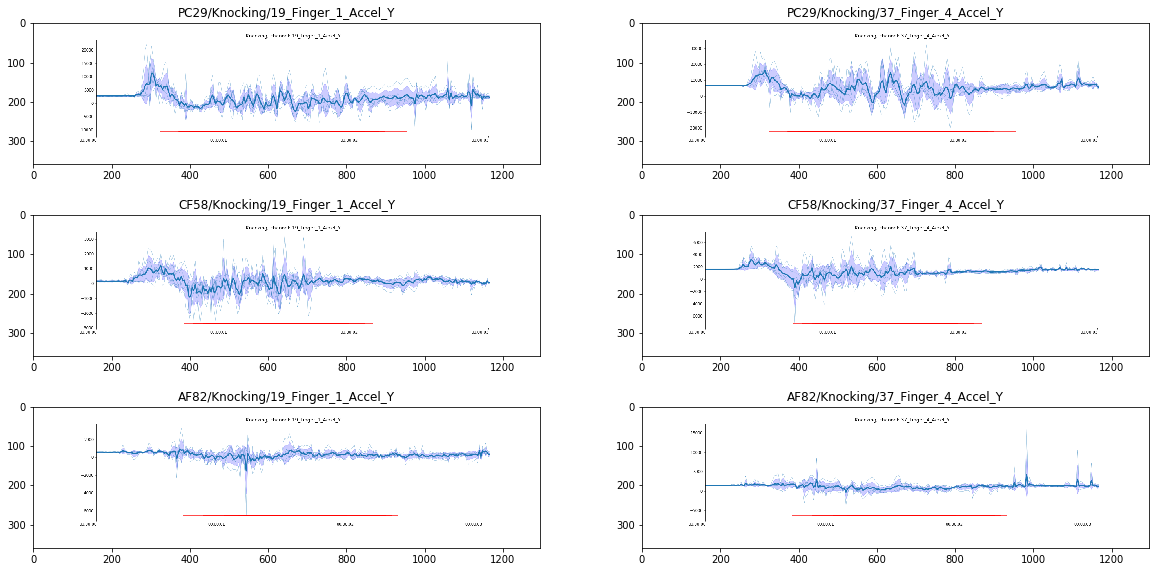

In [15]:
ud_helper.display_random_generated_images(3,1,2)

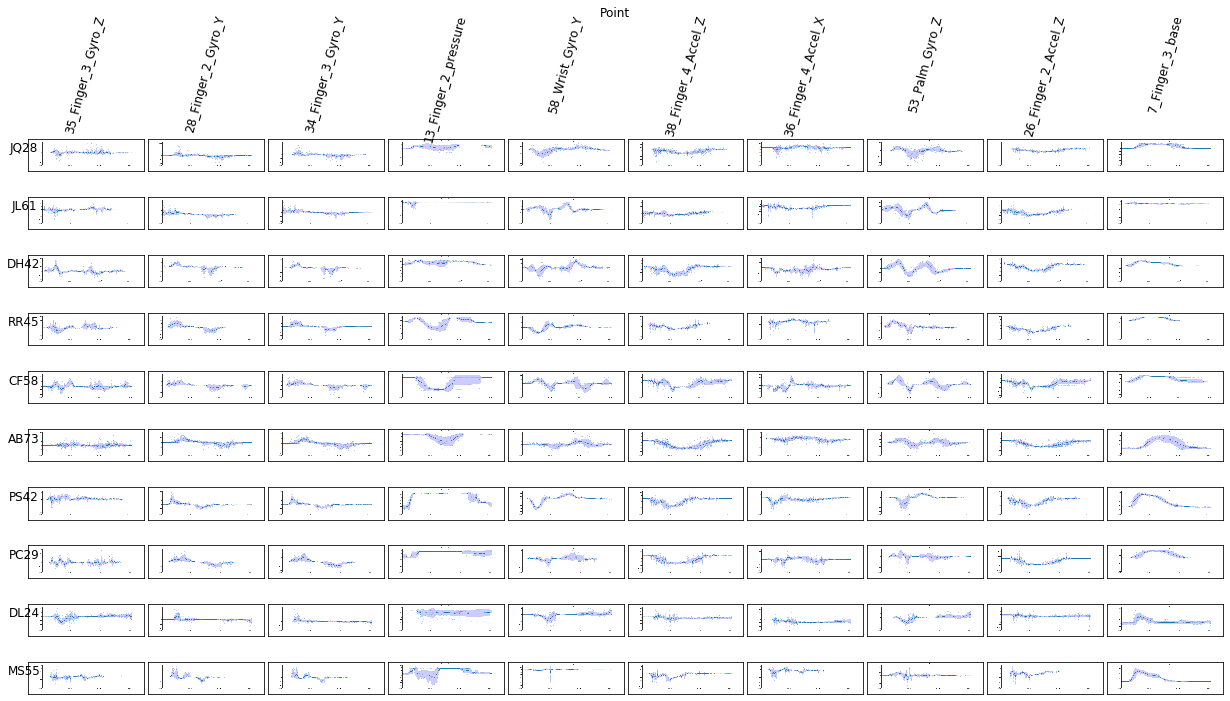

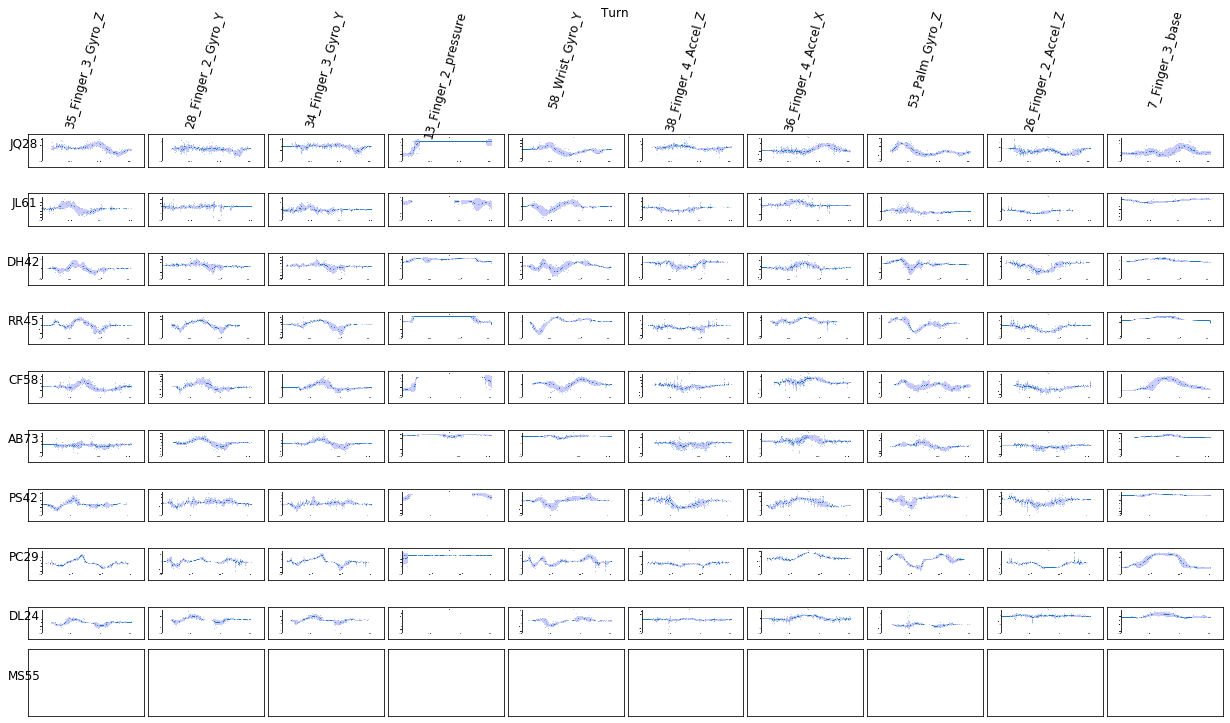

In [36]:
ud_helper.display_random_generated_images(10,2,10)

Given the differences it would be interesting to see what the default template for a gesture over all users look

In [10]:
collector = iutils.AllUsersCollector()
callback, skippable = gci.generate_visualize_all_channel_gesture_combinations_using_all_users_callback(
    users, collector, True)
skippable.mute()
ud_helper.iterate_users_of_gestures(callback)
template = gci.ChannelVisTemplate()
print(collector.current_gesture)
path = iutils.generate_img_base_path('all_users', collector.current_gesture, tqdm.tqdm_notebook([]))
template.visualize_gesture(path, collector.current_gesture, collector.instances_of_all_users, 
                           collector.groups_of_all_users, skippable)
skippable.report()

skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30
(2) Two



skipped #723 image generations


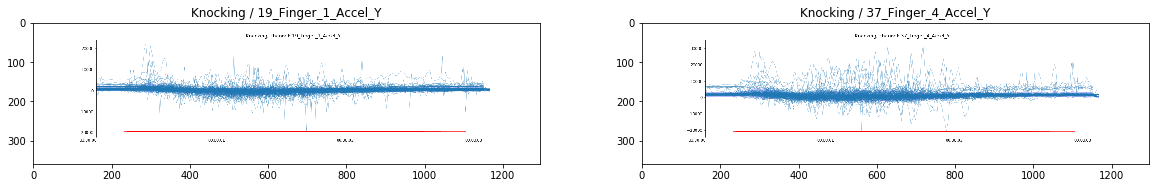

In [38]:
f, axarr = plt.subplots(1, 2, figsize=(20, 10))

axarr[0].set_title(f'Knocking / 19_Finger_1_Accel_Y')
path = f'../figures/raw/all_users/Knocking/19_Finger_1_Accel_Y.png'
a = mpimg.imread(path)
axarr[0].imshow(a)

axarr[1].set_title(f'Knocking / 37_Finger_4_Accel_Y')
path = f'../figures/raw/all_users/Knocking/37_Finger_4_Accel_Y.png'
a = mpimg.imread(path)
axarr[1].imshow(a)

plt.show()

If we look at that result we can see that over all user the start times within an autmatic label varies a lot, and because the peaks then for a movement happen at different times the whole timeseries looks way more chaotic. Still there is more activity going on within the timeframe than outside. In a perfect world the real gesture would always start the same time. If we do that let's see if we get a different image.

In [11]:
collector = iutils.AllUsersCollector()
callback, skippable = gci.generate_visualize_all_channel_gesture_combinations_using_all_users_timealigned_callback(
    users, collector, True)
skippable.mute()
ud_helper.iterate_users_of_gestures(callback)
template = gci.ChannelVisTemplate()
path = iutils.generate_img_base_path('all_users_timealigned', collector.current_gesture, tqdm.tqdm_notebook([]))
template.visualize_gesture(path, collector.current_gesture, collector.instances_of_all_users, 
                           collector.groups_of_all_users, skippable)
skippable.report()

skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30



skipped #723 image generations


We can see that if the manual time starts the same the patterns get a bit clearer. F.e. in Finger 4 Accel Y we can se a relative clear pattern of up and down movements the knocking gesture consists of.

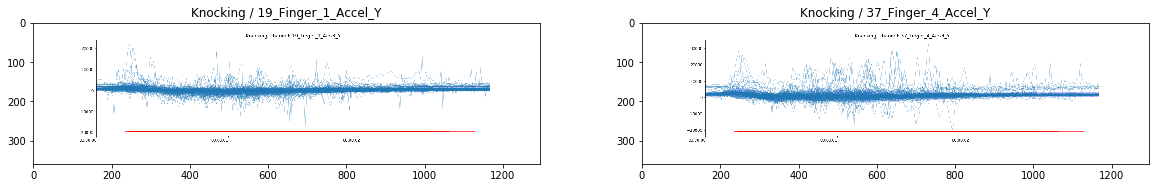

In [40]:
f, axarr = plt.subplots(1, 2, figsize=(20, 10))

axarr[0].set_title(f'Knocking / 19_Finger_1_Accel_Y')
path = f'../figures/raw/all_users_timealigned/Knocking/19_Finger_1_Accel_Y.png'
a = mpimg.imread(path)
axarr[0].imshow(a)

axarr[1].set_title(f'Knocking / 37_Finger_4_Accel_Y')
path = f'../figures/raw/all_users_timealigned/Knocking/37_Finger_4_Accel_Y.png'
a = mpimg.imread(path)
axarr[1].imshow(a)

plt.show()

We now compared the difference in channels for the same gesture among different users or over all users. Another interesting question is, is there a difference for the channel among different gestures. If we f.e. compare some gestures (I took a random selection of Knocking, Weving, Thumbs up and Shoot) for Y Acceleration of Finger 4 we in fact do see very different patterns.

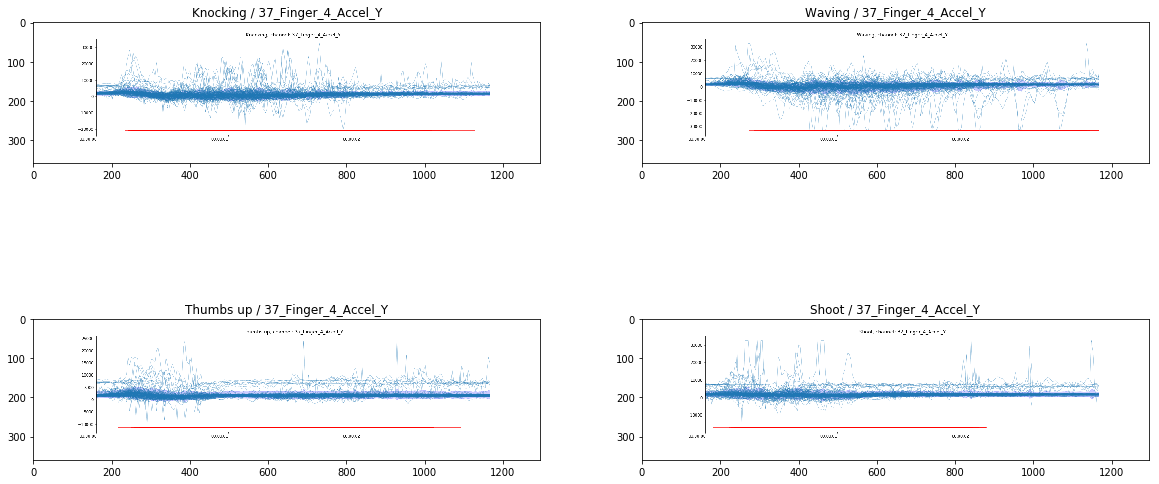

In [41]:
f, axarr = plt.subplots(2, 2, figsize=(20, 10))

axarr[0, 0].set_title(f'Knocking / 37_Finger_4_Accel_Y')
path = f'../figures/raw/all_users_timealigned/Knocking/37_Finger_4_Accel_Y.png'
a = mpimg.imread(path)
axarr[0, 0].imshow(a)

axarr[0, 1].set_title(f'Waving / 37_Finger_4_Accel_Y')
path = f'../figures/raw/all_users_timealigned/Waving/37_Finger_4_Accel_Y.png'
a = mpimg.imread(path)
axarr[0, 1].imshow(a)

axarr[1, 0].set_title(f'Thumbs up / 37_Finger_4_Accel_Y')
path = f'../figures/raw/all_users_timealigned/Thumbs up/37_Finger_4_Accel_Y.png'
a = mpimg.imread(path)
axarr[1, 0].imshow(a)

axarr[1, 1].set_title(f'Shoot / 37_Finger_4_Accel_Y')
path = f'../figures/raw/all_users_timealigned/Shoot/37_Finger_4_Accel_Y.png'
a = mpimg.imread(path)
axarr[1, 1].imshow(a)

plt.show()

In [ ]:
# visualization: what can we do here?
# plot labels with similar avarage raw signals
# 
# plot zero label examples near raw signals

# all for one random user or over all users:

# TODO: since all these things need long time: 
# - First make sure I can run them without a notebook (so there is also a scribt)
# - Secend, even more imporant: Make a function out of it, and control with a parameter overwrite
#   if it actually really recreates the picture if on is already there or not

In [12]:
ghi.generate_all_timing_histograms(users, ud_helper)

skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30
skipped #714 image generations


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30
skipped #714 image generations


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30
skipped #714 image generations


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30
skipped #714 image generations


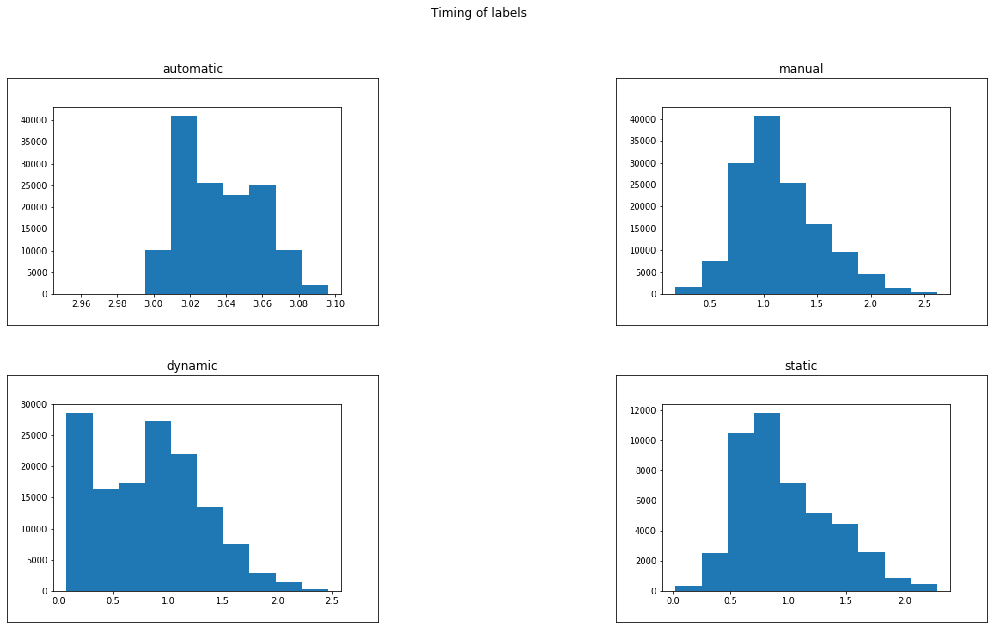

In [43]:
f, axarr = plt.subplots(2, 2, figsize=(20, 10))

axarr[0, 0].set_title(f'automatic')
path = f'../figures/raw/all_users/all_gestures/timing_of_automatic.png'
a = mpimg.imread(path)
axarr[0, 0].imshow(a)
iutils.hide_ticks_in_grid(0,0,axarr)

axarr[0, 1].set_title(f'manual')
path = f'../figures/raw/all_users/all_gestures/timing_of_manual.png'
a = mpimg.imread(path)
axarr[0, 1].imshow(a)
iutils.hide_ticks_in_grid(0,1,axarr)

axarr[1, 0].set_title(f'dynamic')
path = f'../figures/raw/all_users/all_gestures/timing_of_dynamic.png'
a = mpimg.imread(path)
axarr[1, 0].imshow(a)
iutils.hide_ticks_in_grid(1,0,axarr)

axarr[1, 1].set_title(f'static')
path = f'../figures/raw/all_users/all_gestures/timing_of_static.png'
a = mpimg.imread(path)
axarr[1, 1].imshow(a)
iutils.hide_ticks_in_grid(1,1,axarr)

plt.suptitle('Timing of labels')

plt.show()

#### Value Ranges

Next we look at the value ranges for each Channel/Sensor in the Dataset. This can enable us to deal with outliers, and look on a very high level on differences between users.

TODO: For the overall distribution of values in the chanels, make t-tests and so to compare them...

In [13]:
cols = users['AB73']['glove_merged'].columns
all_accel = Constants().raw_indices['accel']
print(cols[all_accel])

Index(['18_Finger_1_Accel_X', '19_Finger_1_Accel_Y', '20_Finger_1_Accel_Z',
       '24_Finger_2_Accel_X', '25_Finger_2_Accel_Y', '26_Finger_2_Accel_Z',
       '30_Finger_3_Accel_X', '31_Finger_3_Accel_Y', '32_Finger_3_Accel_Z',
       '36_Finger_4_Accel_X', '37_Finger_4_Accel_Y', '38_Finger_4_Accel_Z',
       '42_Thumb_Accel_X', '43_Thumb_Accel_Y', '44_Thumb_Accel_Z',
       '48_Palm_Accel_X', '49_Palm_Accel_Y', '50_Palm_Accel_Z',
       '54_Wrist_Accel_X', '55_Wrist_Accel_Y', '56_Wrist_Accel_Z'],
      dtype='object')


In [14]:
higher_percentile = 98.5
lower_percentile = 1.5

In [15]:
def describe_value_range(columes, remove_outliers, show_overal):
    def describe_values(line, username):
        print('user: ', username)
        print(pd.DataFrame(data=line).describe())
        print("")
    all_vals = sutils.collect_values(usernames, users, columes, remove_outliers, 
                                     higher_percentile, lower_percentile, 
                                     True, describe_values, use_tqtm=True)
    if show_overal:
        print(pd.DataFrame(data=all_vals).describe())

In [16]:
idx_keys = Constants().raw_indices.keys()
print(idx_keys)

dict_keys(['flex', 'pressure', 'accel', 'gyro', 'magnetometer', 'lin_accel', 'thumb', 'finger_1', 'finger_2', 'finger_3', 'finger_4', 'wrist', 'palm'])


In [12]:
describe_value_range(cols[all_accel], True, False)

user:  AB73
                  0
count  3.843168e+06
mean   4.253109e+02
std    1.096032e+03
min   -2.247000e+03
25%   -5.920000e+02
50%    6.710000e+02
75%    1.346000e+03
max    2.313000e+03

skipping userAE30
user:  AF82
                  0
count  2.222535e+06
mean   3.296671e+02
std    1.114297e+03
min   -2.098000e+03
25%   -7.140000e+02
50%    3.770000e+02
75%    1.424000e+03
max    2.208000e+03

user:  AL29
                  0
count  3.869796e+06
mean   4.380956e+02
std    1.079509e+03
min   -2.031000e+03
25%   -5.490000e+02
50%    4.100000e+02
75%    1.501000e+03
max    2.293000e+03

user:  AW18
                  0
count  2.166339e+06
mean   3.938461e+02
std    1.110300e+03
min   -2.305000e+03
25%   -5.030000e+02
50%    5.940000e+02
75%    1.287000e+03
max    2.338000e+03

user:  CB23
                  0
count  2.211951e+06
mean   5.256775e+02
std    1.062236e+03
min   -2.179000e+03
25%   -2.490000e+02
50%    4.340000e+02
75%    1.520000e+03
max    2.353000e+03

user:  CB24
     

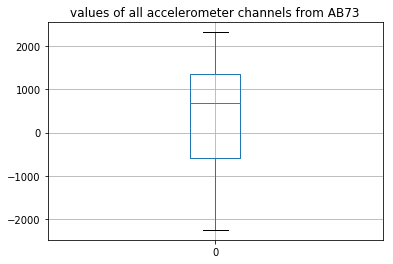

skipping userAE30


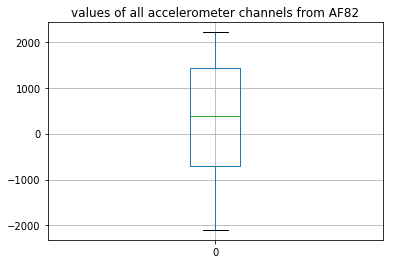

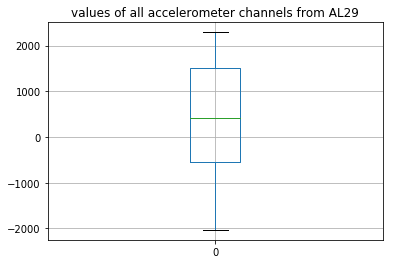

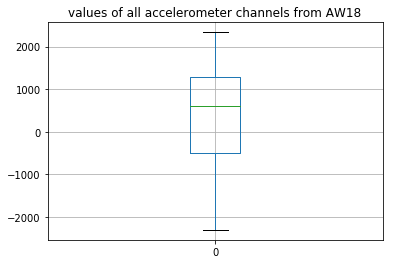

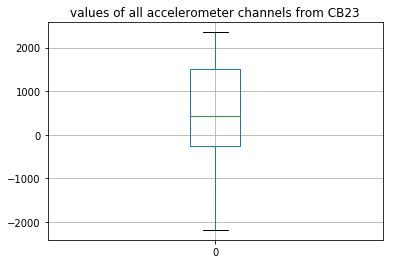

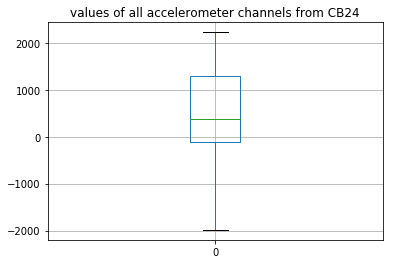

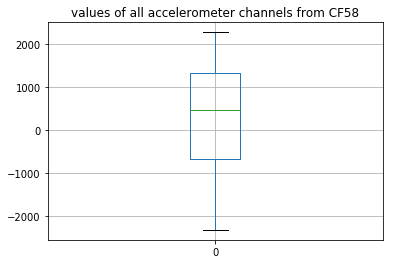

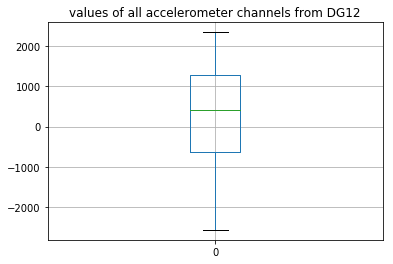

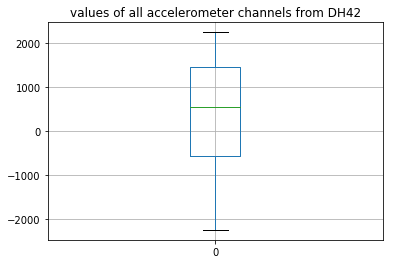

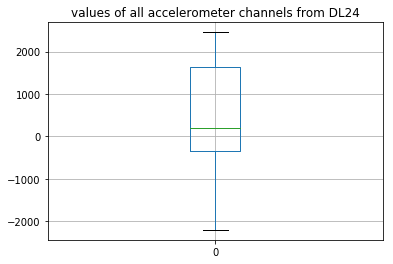

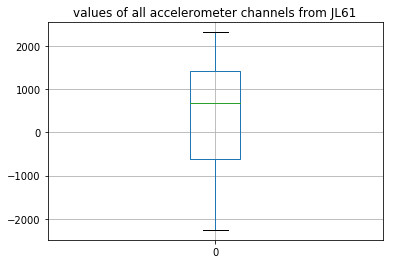

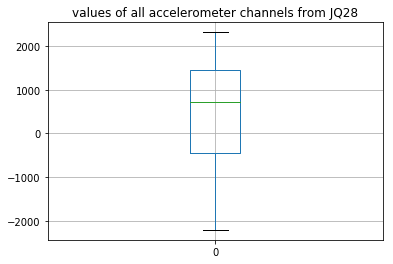

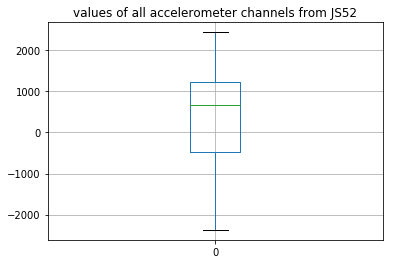

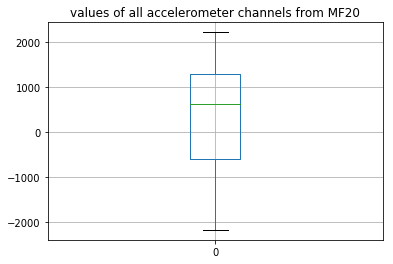

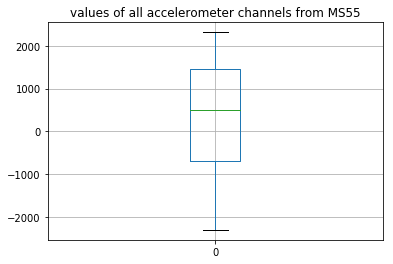

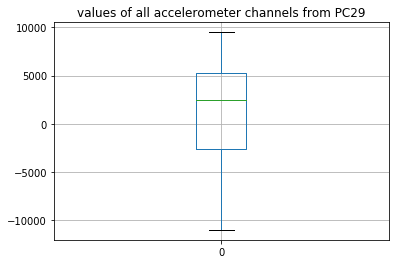

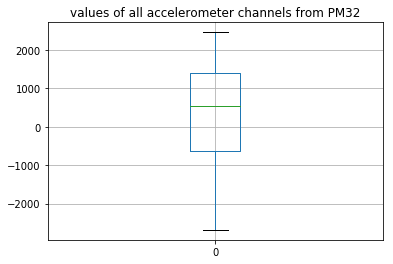

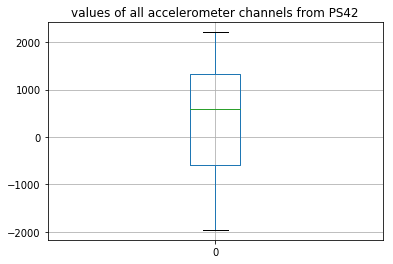

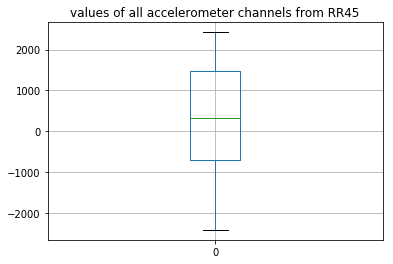

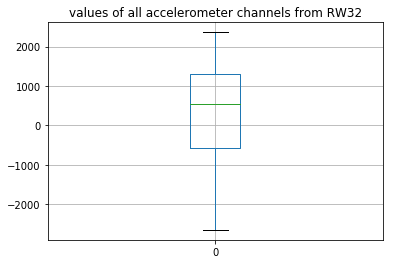

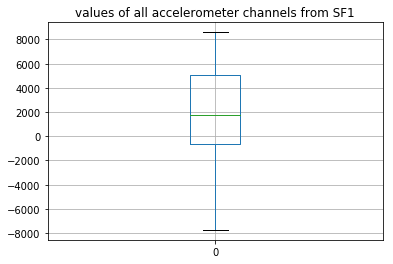

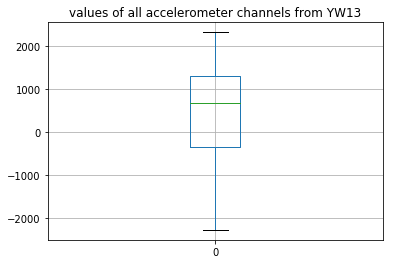

In [56]:
gbo.show_valuerange_individual_boxplots(usernames, users, 'all accelerometer channels', cols[all_accel], 
                                        True, higher_percentile, lower_percentile, False, False)

In [57]:
all_gyro = Constants().raw_indices['gyro']
print(cols[all_gyro])

Index(['21_Finger_1_Gyro_X', '22_Finger_1_Gyro_Y', '23_Finger_1_Gyro_Z',
       '27_Finger_2_Gyro_X', '28_Finger_2_Gyro_Y', '29_Finger_2_Gyro_Z',
       '33_Finger_3_Gyro_X', '34_Finger_3_Gyro_Y', '35_Finger_3_Gyro_Z',
       '39_Finger_4_Gyro_X', '40_Finger_4_Gyro_Y', '41_Finger_4_Gyro_Z',
       '45_Thumb_Gyro_X', '46_Thumb_Gyro_Y', '47_Thumb_Gyro_Z',
       '51_Palm_Gyro_X', '52_Palm_Gyro_Y', '53_Palm_Gyro_Z', '57_Wrist_Gyro_X',
       '58_Wrist_Gyro_Y', '59_Wrist_Gyro_Z'],
      dtype='object')


In [60]:
describe_value_range(cols[all_gyro], True, False)

user:  AB73
                  0
count  3.843168e+06
mean  -1.524872e+01
std    7.369976e+02
min   -3.623000e+03
25%   -4.300000e+01
50%   -1.000000e+00
75%    3.800000e+01
max    3.490000e+03

skipping userAE30
user:  AF82
                  0
count  2.222535e+06
mean  -1.009352e+01
std    6.580186e+02
min   -3.211000e+03
25%   -4.300000e+01
50%   -3.000000e+00
75%    3.100000e+01
max    3.287000e+03

user:  AL29
                  0
count  3.869796e+06
mean  -1.501949e+01
std    6.743646e+02
min   -3.154000e+03
25%   -4.200000e+01
50%   -3.000000e+00
75%    3.000000e+01
max    3.172000e+03

user:  AW18
                  0
count  2.166339e+06
mean  -1.664590e+01
std    6.459756e+02
min   -3.408000e+03
25%   -3.700000e+01
50%   -3.000000e+00
75%    3.300000e+01
max    3.081000e+03

user:  CB23
                  0
count  2.211951e+06
mean  -1.660161e+01
std    5.905053e+02
min   -2.990000e+03
25%   -5.300000e+01
50%   -7.000000e+00
75%    4.400000e+01
max    2.667000e+03

user:  CB24
     

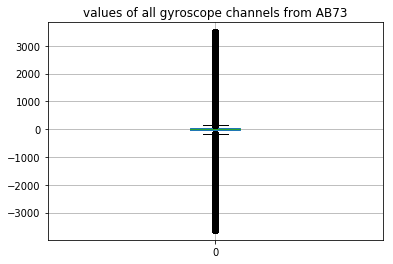

skipping userAE30


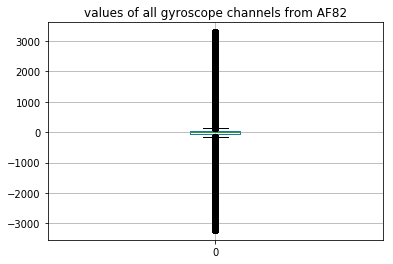

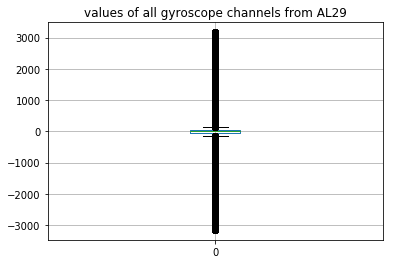

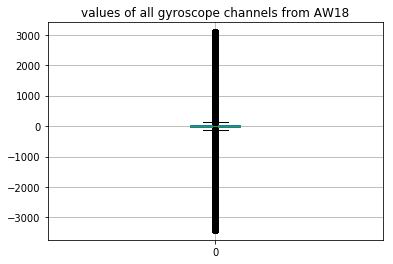

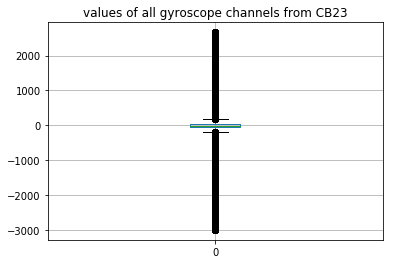

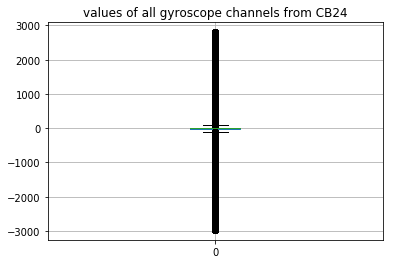

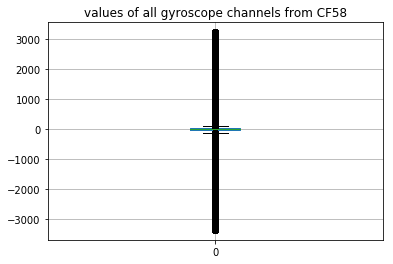

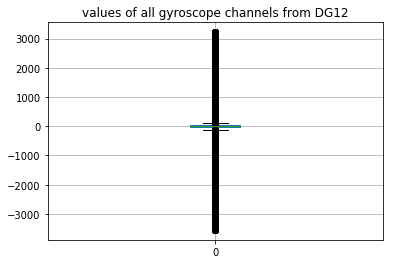

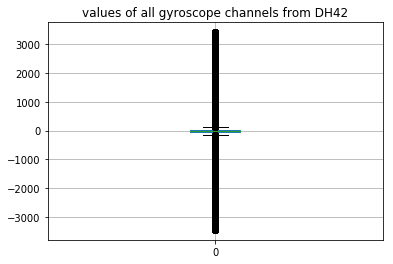

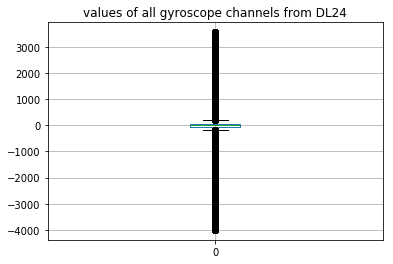

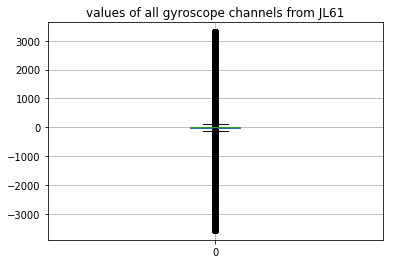

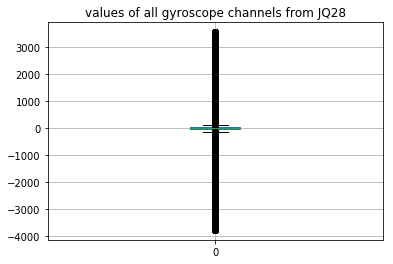

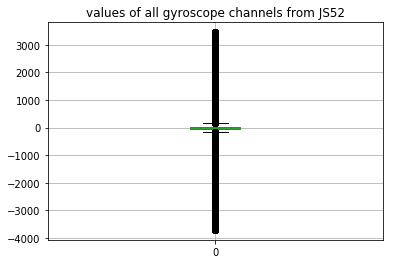

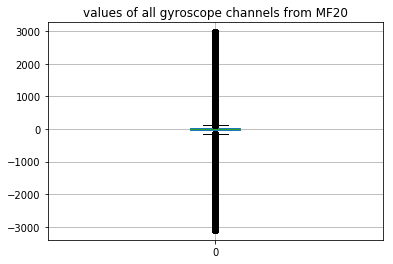

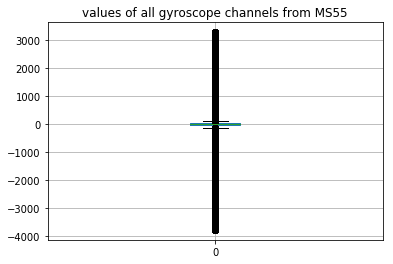

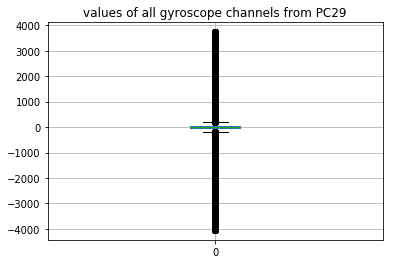

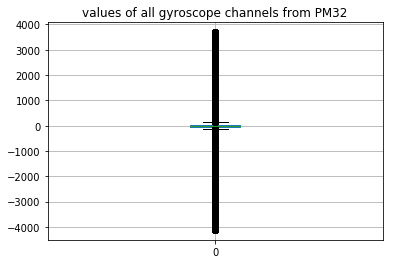

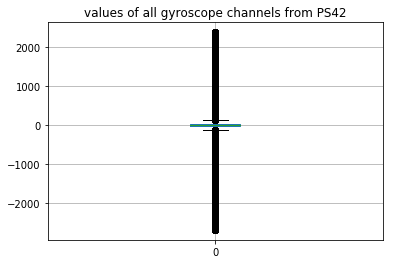

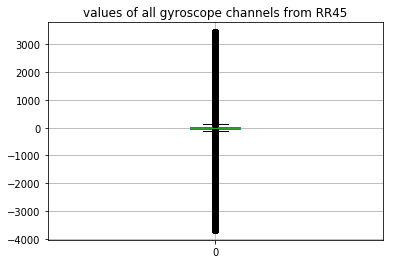

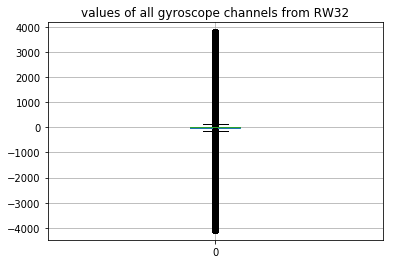

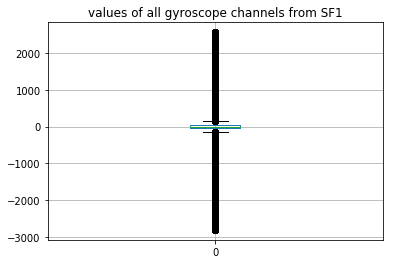

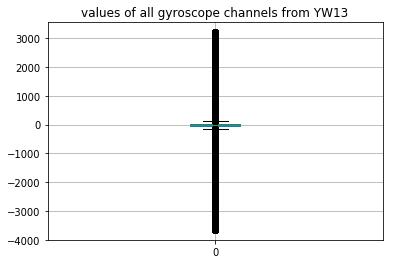

In [61]:
gbo.show_valuerange_individual_boxplots(usernames, users, 'all gyroscope channels', cols[all_gyro], 
                                        True, higher_percentile, lower_percentile, False, False)

In [62]:
all_flex = Constants().raw_indices['flex']['all']
print(cols[all_flex])

Index(['0_Thumb_base', '2_Angle_between_thumb_and_hand', '3_Finger_1_base',
       '4_Finger_1_tip', '5_Finger_2_base', '6_Finger_2_tip',
       '7_Finger_3_base', '8_Finger_3_tip', '9_Finger_4_base',
       '10_Finger_4_tip', '11_Thumb_tip', '16_Wrist_extension',
       '17_Wrist_flexion'],
      dtype='object')


In [63]:
describe_value_range(cols[all_flex], True, False)

user:  AB73
                  0
count  2.379104e+06
mean   1.772701e+03
std    2.868182e+02
min    1.136000e+03
25%    1.624000e+03
50%    1.803000e+03
75%    1.975000e+03
max    2.314000e+03

skipping userAE30
user:  AF82
                  0
count  1.375855e+06
mean   1.755300e+03
std    2.675732e+02
min    1.162000e+03
25%    1.629000e+03
50%    1.759000e+03
75%    1.931000e+03
max    2.282000e+03

user:  AL29
                  0
count  2.395588e+06
mean   1.698773e+03
std    2.545248e+02
min    1.166000e+03
25%    1.592000e+03
50%    1.718000e+03
75%    1.857000e+03
max    2.222000e+03

user:  AW18
                  0
count  1.341067e+06
mean   1.709894e+03
std    2.943142e+02
min    1.093000e+03
25%    1.600000e+03
50%    1.725000e+03
75%    1.909000e+03
max    2.250000e+03

user:  CB23
                  0
count  1.369303e+06
mean   1.754792e+03
std    3.325143e+02
min    1.039000e+03
25%    1.623000e+03
50%    1.806000e+03
75%    1.997000e+03
max    2.309000e+03

user:  CB24
     

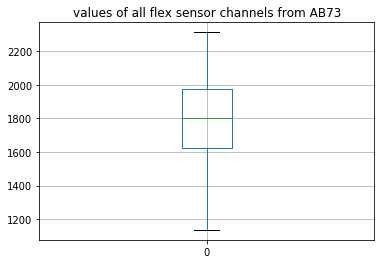

skipping userAE30


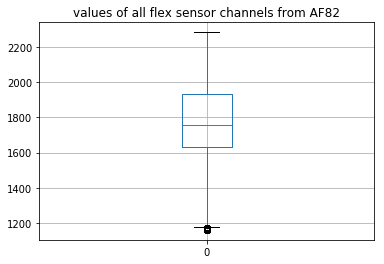

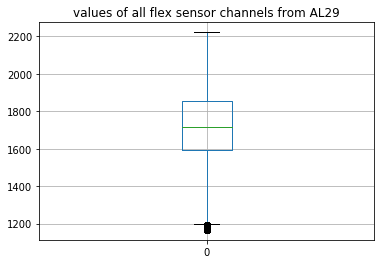

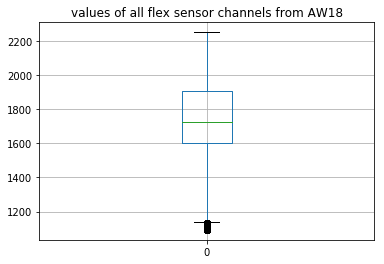

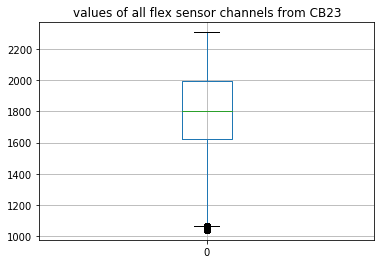

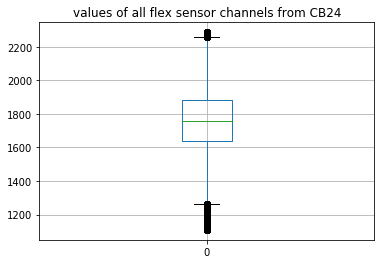

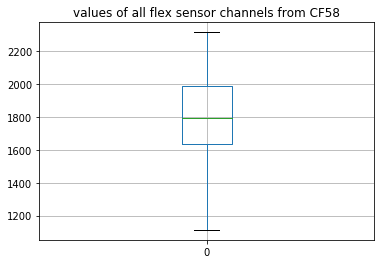

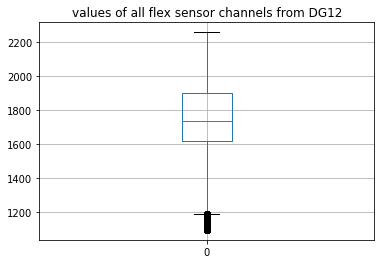

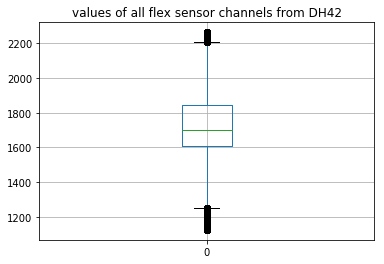

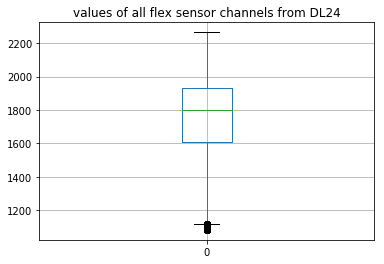

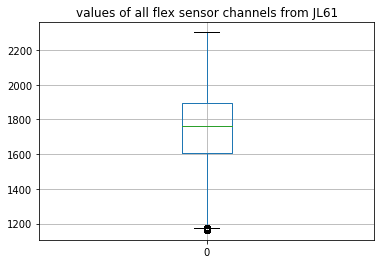

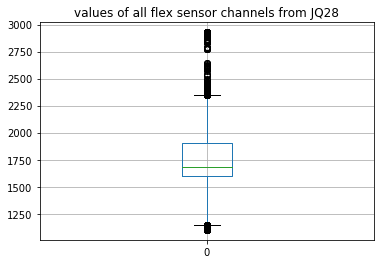

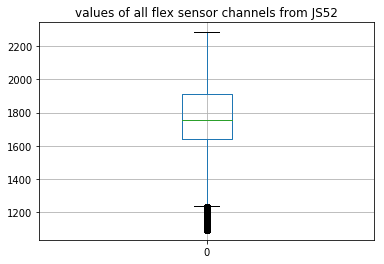

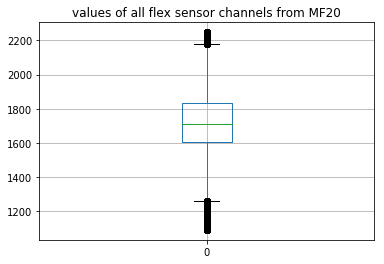

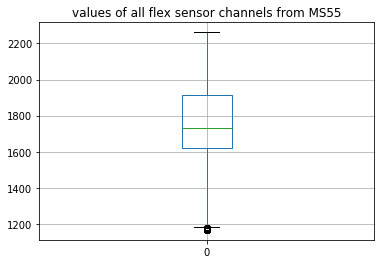

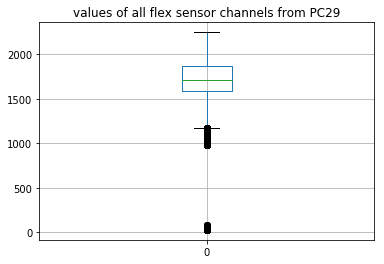

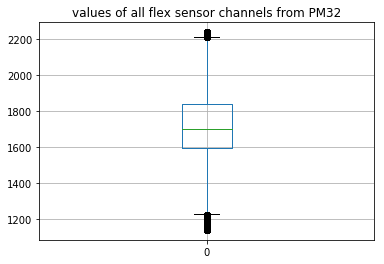

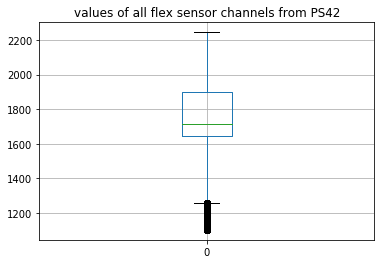

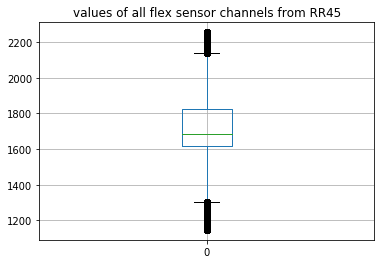

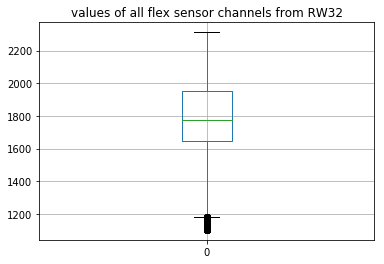

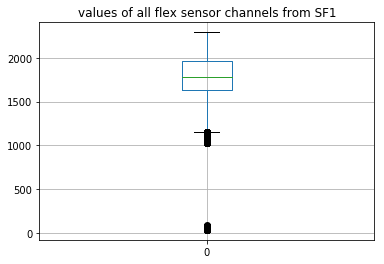

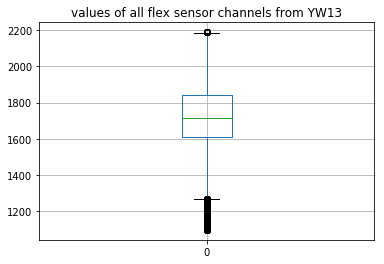

In [64]:
gbo.show_valuerange_individual_boxplots(usernames, users, 'all flex sensor channels', cols[all_flex], 
                                        True, higher_percentile, lower_percentile, False, False)

skipping userAE30


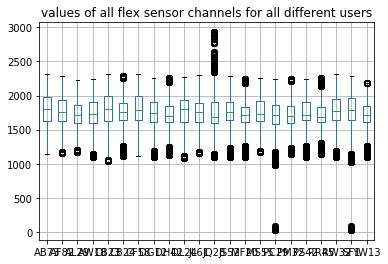

In [66]:
gbo.show_valuerange_boxplots_in_one_image(usernames, users, 'all flex sensor channels', cols[all_flex], 
                                        True, higher_percentile, lower_percentile, False, False)

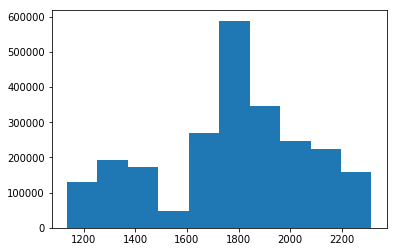

skipping userAE30


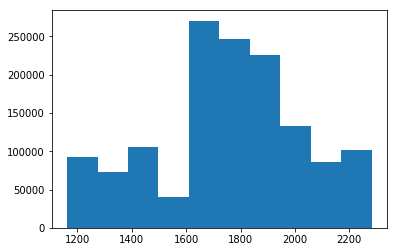

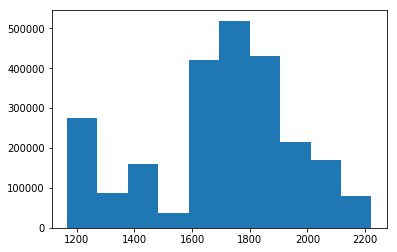

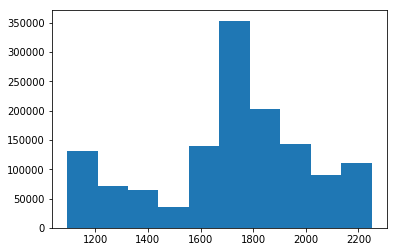

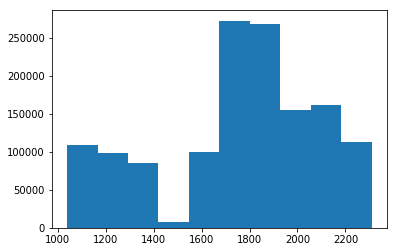

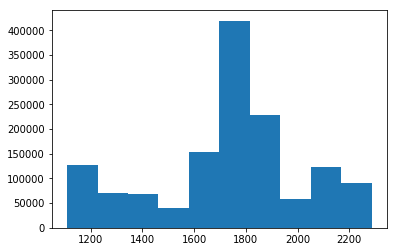

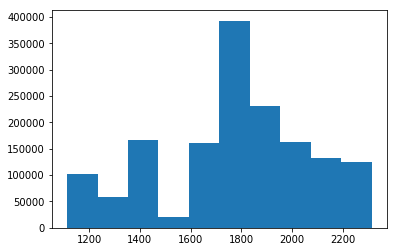

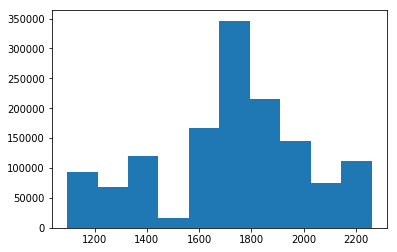

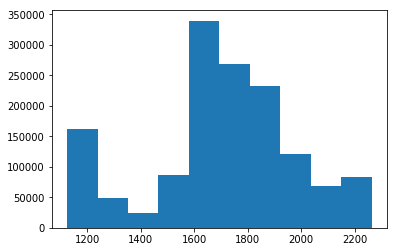

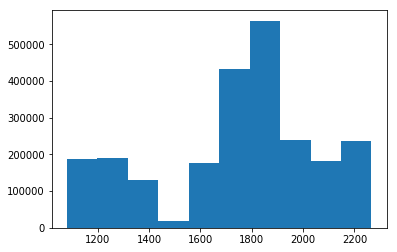

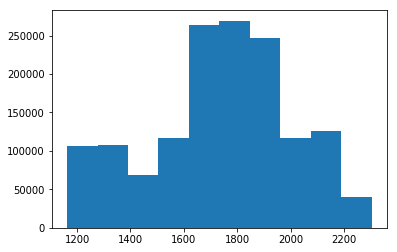

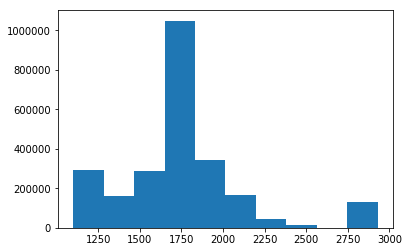

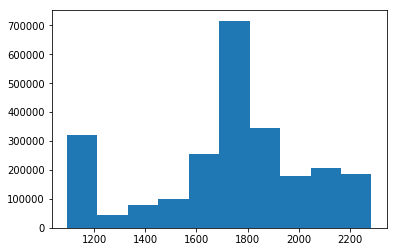

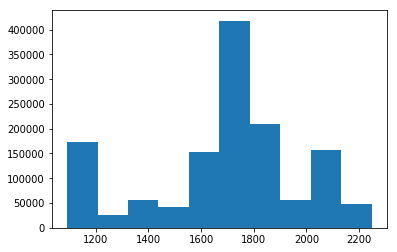

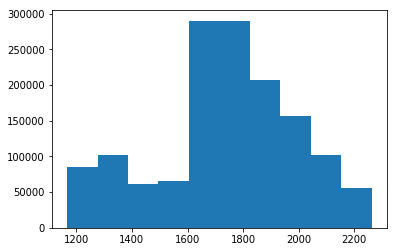

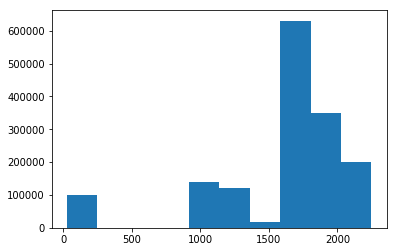

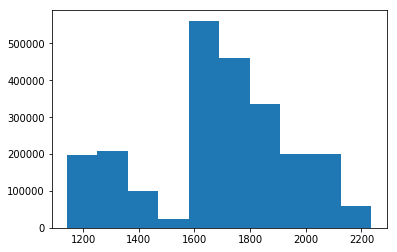

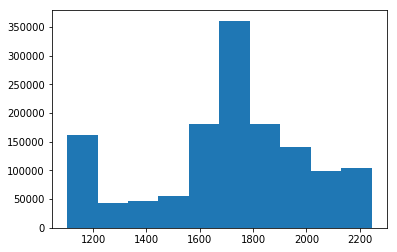

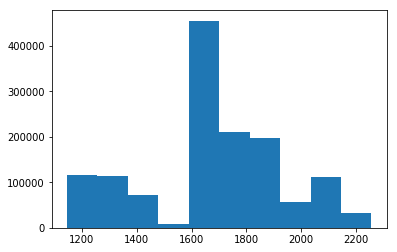

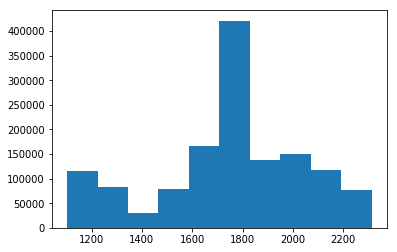

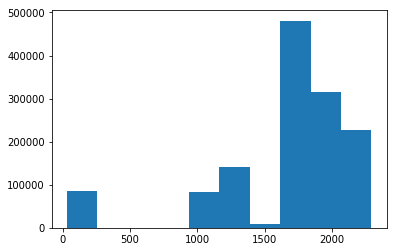

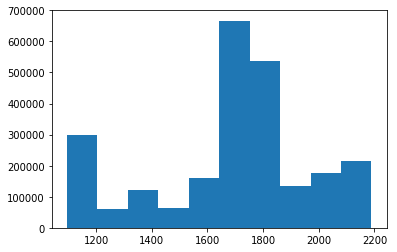

In [67]:
ghi.show_valuerange_histograms(usernames, users, cols[all_flex], 
                               True, higher_percentile, lower_percentile, 
                               False, False)

In [ ]:
# so, the next step in the story is this: 
# Are these variations mainly the 0 class or mainly the 
# way gestures are done?
# 
# To prove that I seperate the data into clearly 0 class 
# instances (everything outside the automatic) labeling,
# and into clearly geatures (everything inside the manual
# labeling)

skipping userAE30


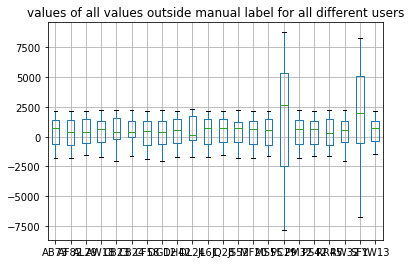

In [70]:
gbo.show_valuerange_boxplots_in_one_imagefor_label_type_and_gesture(
    usernames, users, 'all values outside manual label', cols[all_accel], 
    'label_manual', 'zero_class', True, higher_percentile, lower_percentile, False, False)

skipping userAE30


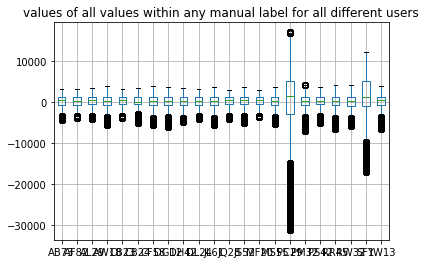

In [69]:
gbo.show_valuerange_boxplots_in_one_imagefor_label_type_and_gesture(
    usernames, users, 'all values within any manual label', cols[all_accel], 
    'label_manual', 'all_labels', True, higher_percentile, lower_percentile, False, False)
#show_boxplots_row_lc(cols[all_accel], 'label_manual', 'all_labels', True, False)

### Test vor Normal Distribution

The values of the sensors overall and for gestures seems to be normal distributed in the large. To thest for that I perform a students t-test for the values distribution of each individual sensor and the distribution of sensor - gesture pairs. The results are summariezed in the following Table:

In [47]:
def print_for_console(uname, vmin, vmax, n, k2, p):
    print(f'user: {uname}')
    print(f'n: {n}, min: {vmin:e}, max: {vmax:e}')
    print(f'k2: {k2:e} p = {p:e}')

def print_table_markdown_header():
    print(f'| Name | N | Min | Max | K2 | P |')
    print(f'| ---- | - | --- | --- | -- | - |')

def print_table_for_markdown(uname, vmin, vmax, n, k2, p):
    print(f'| {uname} | {n:e}  | {vmin:e} | {vmax:e} | {k2:e} | {p:e} |')

In [51]:
#print_table_markdown_header()
vals = values_per_user(cols[all_accel], True, True)
for v, u in vals:
    vmin, vmax = v.min(), v.max()
    n = len(v)
    k2, p = sp.stats.normaltest(v)
    #print_table_for_markdown(u, vmin, vmax, n, k2, p)
    print_for_console(u, vmin, vmax, n, k2, p)

user: AB73
n: 3843168, min: -2.247000e+03, max: 2.313000e+03
k2: 1.332371e+06 p = 0.000000e+00
skipping userAE30
user: AF82
n: 2222535, min: -2.098000e+03, max: 2.208000e+03
k2: 3.965770e+06 p = 0.000000e+00
user: AL29
n: 3869796, min: -2.031000e+03, max: 2.293000e+03
k2: 3.432655e+08 p = 0.000000e+00
user: AW18
n: 2166339, min: -2.305000e+03, max: 2.338000e+03
k2: 5.806311e+05 p = 0.000000e+00
user: CB23
n: 2211951, min: -2.179000e+03, max: 2.353000e+03
k2: 2.208363e+05 p = 0.000000e+00
user: CB24
n: 2227722, min: -1.986000e+03, max: 2.226000e+03
k2: 1.704378e+05 p = 0.000000e+00
user: CF58
n: 2505216, min: -2.330000e+03, max: 2.275000e+03
k2: 1.501297e+06 p = 0.000000e+00
user: DG12
n: 2195571, min: -2.559000e+03, max: 2.333000e+03
k2: 7.056697e+05 p = 0.000000e+00
user: DH42
n: 2319135, min: -2.253000e+03, max: 2.249000e+03
k2: 2.388734e+06 p = 0.000000e+00
user: DL24
n: 3806838, min: -2.205000e+03, max: 2.454000e+03
k2: 1.443842e+06 p = 0.000000e+00
user: JL61
n: 2363886, min: -2.2

The following table shows a test if the values of all accelerometer channels (each sensor, x,y,z taken together) are thrown together they are not even near a normal distribution for each user. So to compare them a non-parametric comparison must be taken.

| Name | N | Min | Max | K2 | P |
| ---- | - | --- | --- | -- | - |
| AB73 | 3.843168e+06  | -2.247000e+03 | 2.313000e+03 | 1.332371e+06 | 0.000000e+00 |
| AF82 | 2.222535e+06  | -2.098000e+03 | 2.208000e+03 | 3.965770e+06 | 0.000000e+00 |
| AL29 | 3.869796e+06  | -2.031000e+03 | 2.293000e+03 | 3.432655e+08 | 0.000000e+00 |
| AW18 | 2.166339e+06  | -2.305000e+03 | 2.338000e+03 | 5.806311e+05 | 0.000000e+00 |
| CB23 | 2.211951e+06  | -2.179000e+03 | 2.353000e+03 | 2.208363e+05 | 0.000000e+00 |
| CB24 | 2.227722e+06  | -1.986000e+03 | 2.226000e+03 | 1.704378e+05 | 0.000000e+00 |
| CF58 | 2.505216e+06  | -2.330000e+03 | 2.275000e+03 | 1.501297e+06 | 0.000000e+00 |
| DG12 | 2.195571e+06  | -2.559000e+03 | 2.333000e+03 | 7.056697e+05 | 0.000000e+00 |
| DH42 | 2.319135e+06  | -2.253000e+03 | 2.249000e+03 | 2.388734e+06 | 0.000000e+00 |
| DL24 | 3.806838e+06  | -2.205000e+03 | 2.454000e+03 | 1.443842e+06 | 0.000000e+00 |
| JL61 | 2.363886e+06  | -2.256000e+03 | 2.315000e+03 | 2.478691e+06 | 0.000000e+00 |
| JQ28 | 4.023516e+06  | -2.206000e+03 | 2.314000e+03 | 2.761341e+06 | 0.000000e+00 |
| JS52 | 3.936009e+06  | -2.372000e+03 | 2.440000e+03 | 8.583538e+05 | 0.000000e+00 |
| MF20 | 2.163441e+06  | -2.167000e+03 | 2.212000e+03 | 7.814999e+05 | 0.000000e+00 |
| MS55 | 2.285892e+06  | -2.308000e+03 | 2.320000e+03 | 4.337789e+06 | 0.000000e+00 |
| PC29 | 2.522898e+06  | -1.098600e+04 | 9.480000e+03 | 6.032791e+05 | 0.000000e+00 |
| PM32 | 3.794028e+06  | -2.685000e+03 | 2.465000e+03 | 1.420897e+06 | 0.000000e+00 |
| PS42 | 2.221695e+06  | -1.959000e+03 | 2.208000e+03 | 4.562585e+06 | 0.000000e+00 |
| RR45 | 2.218671e+06  | -2.419000e+03 | 2.423000e+03 | 5.364713e+06 | 0.000000e+00 |
| RW32 | 2.222241e+06  | -2.656000e+03 | 2.364000e+03 | 3.347358e+05 | 0.000000e+00 |
| SF1  | 2.167305e+06  | -7.738000e+03 | 8.598000e+03 | 2.609429e+05 | 0.000000e+00 |
| YW13 | 3.928722e+06  | -2.283000e+03 | 2.316000e+03 | 1.276646e+06 | 0.000000e+00 |


In fact, if we test the distribution of the pure values for each individual channel for each user, than all of them are not even nearly normal distributed. With a null hypthesis that they are normal distributet, the students t-test gives a p value below 0.001 for each of them beside the Thumb base flex sensor of user AE30, who still is significantly not-normal as the p value is 0.02385297 which is still below 0.05

In [55]:
#print_table_markdown_header()
# test each channel in the data if it is not normal distibuted:
alpha = 0.001
for c in cols[:-7]:
    vals = values_per_user(c, True, True)
    for v, u in vals:
        vmin, vmax = v.min(), v.max()
        n = len(v)
        k2, p = sp.stats.normaltest(v)
        if p > alpha:
            print('maybe normal: ', c)
            print_for_console(u, vmin, vmax, n, k2, p)

skipping userAE30
maybe normal:  0_Thumb_base
user: DG12
n: 104551, min: 1.689000e+03, max: 1.916000e+03
k2: 7.471693e+00 p = 2.385297e-02


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


In [35]:
len(all_accel)

21

It is interesting to compare the distributions of the overal data between the zero class and the individual gestures for each sensor. Since we have prooven that these data is not normal distributed we need another means to compare these data. Several options exist: The Kolmogorov–Smirnov test in form of the two-sample K–S test, the Anderson–Darling test as a K-Sample Anderson–Darling test, the Kuiper's test and maybe others. The Kolmogorov–Smirnov is realively well esteblished to make pairwise comparison, which is what I want to do, so we choose this one.

In [27]:
vpu = functools.partial(sutils.values_per_user, remove_outliers=True,
                    higher_percentile=higher_percentile, lower_percentile=lower_percentile, use_tqtm=False)

for c1 in cols[:-7]:
    for c2 in cols[:-7]:
        for u in usernames:
            users[u][f'{c1}-{c2}'] = []

for c1 in cols[:-7]:
    for c2 in cols[:-7]:
        print('--------------------------')
        print(f'channel {c1} <-> channel {c2}')
        val1 = vpu(usernames, users, c1)
        val2 = vpu(usernames, users, c2)
        for (v1, u1), (v2, u2) in zip(val1, val2):
            if u1 != u2:
                print('user different?', u1, u2)
                continue
            users[u1][f'{c1}-{c2}'].append(sp.stats.ks_2samp(v1, v2))

--------------------------
channel 0_Thumb_base <-> channel 0_Thumb_base
skipping userAE30
skipping userAE30
--------------------------
channel 0_Thumb_base <-> channel 1_Thumb_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 0_Thumb_base <-> channel 2_Angle_between_thumb_and_hand
skipping userAE30
skipping userAE30
--------------------------
channel 0_Thumb_base <-> channel 3_Finger_1_base
skipping userAE30
skipping userAE30
--------------------------
channel 0_Thumb_base <-> channel 4_Finger_1_tip
skipping userAE30
skipping userAE30
--------------------------
channel 0_Thumb_base <-> channel 5_Finger_2_base
skipping userAE30
skipping userAE30
--------------------------
channel 0_Thumb_base <-> channel 6_Finger_2_tip
skipping userAE30
skipping userAE30
--------------------------
channel 0_Thumb_base <-> channel 7_Finger_3_base
skipping userAE30
skipping userAE30
--------------------------
channel 0_Thumb_base <-> channel 8_Finger_3_tip
skipping userAE30


--------------------------
channel 1_Thumb_pressure <-> channel 9_Finger_4_base
skipping userAE30
skipping userAE30
--------------------------
channel 1_Thumb_pressure <-> channel 10_Finger_4_tip
skipping userAE30
skipping userAE30
--------------------------
channel 1_Thumb_pressure <-> channel 11_Thumb_tip
skipping userAE30
skipping userAE30
--------------------------
channel 1_Thumb_pressure <-> channel 12_Finger_1_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 1_Thumb_pressure <-> channel 13_Finger_2_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 1_Thumb_pressure <-> channel 14_Finger_3_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 1_Thumb_pressure <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 1_Thumb_pressure <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 1_Thumb_pressure 

--------------------------
channel 2_Angle_between_thumb_and_hand <-> channel 14_Finger_3_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 2_Angle_between_thumb_and_hand <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 2_Angle_between_thumb_and_hand <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 2_Angle_between_thumb_and_hand <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------
channel 2_Angle_between_thumb_and_hand <-> channel 18_Finger_1_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 2_Angle_between_thumb_and_hand <-> channel 19_Finger_1_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 2_Angle_between_thumb_and_hand <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 2_Angle_between_thumb_and_han

--------------------------
channel 3_Finger_1_base <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 3_Finger_1_base <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 3_Finger_1_base <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------
channel 3_Finger_1_base <-> channel 18_Finger_1_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 3_Finger_1_base <-> channel 19_Finger_1_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 3_Finger_1_base <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 3_Finger_1_base <-> channel 21_Finger_1_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 3_Finger_1_base <-> channel 22_Finger_1_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 3_Finger_1_base <-

--------------------------
channel 4_Finger_1_tip <-> channel 23_Finger_1_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 4_Finger_1_tip <-> channel 24_Finger_2_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 4_Finger_1_tip <-> channel 25_Finger_2_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 4_Finger_1_tip <-> channel 26_Finger_2_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 4_Finger_1_tip <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 4_Finger_1_tip <-> channel 28_Finger_2_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 4_Finger_1_tip <-> channel 29_Finger_2_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 4_Finger_1_tip <-> channel 30_Finger_3_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 4_Finger_1_tip <-> channe

--------------------------
channel 5_Finger_2_base <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 5_Finger_2_base <-> channel 32_Finger_3_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 5_Finger_2_base <-> channel 33_Finger_3_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 5_Finger_2_base <-> channel 34_Finger_3_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 5_Finger_2_base <-> channel 35_Finger_3_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 5_Finger_2_base <-> channel 36_Finger_4_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 5_Finger_2_base <-> channel 37_Finger_4_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 5_Finger_2_base <-> channel 38_Finger_4_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 5_Finger_2_base 

--------------------------
channel 6_Finger_2_tip <-> channel 39_Finger_4_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 6_Finger_2_tip <-> channel 40_Finger_4_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 6_Finger_2_tip <-> channel 41_Finger_4_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 6_Finger_2_tip <-> channel 42_Thumb_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 6_Finger_2_tip <-> channel 43_Thumb_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 6_Finger_2_tip <-> channel 44_Thumb_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 6_Finger_2_tip <-> channel 45_Thumb_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 6_Finger_2_tip <-> channel 46_Thumb_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 6_Finger_2_tip <-> channel 47_Thumb_Gyro_

--------------------------
channel 7_Finger_3_base <-> channel 47_Thumb_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 7_Finger_3_base <-> channel 48_Palm_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 7_Finger_3_base <-> channel 49_Palm_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 7_Finger_3_base <-> channel 50_Palm_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 7_Finger_3_base <-> channel 51_Palm_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 7_Finger_3_base <-> channel 52_Palm_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 7_Finger_3_base <-> channel 53_Palm_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 7_Finger_3_base <-> channel 54_Wrist_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 7_Finger_3_base <-> channel 55_Wrist_Accel_Y
sk

--------------------------
channel 8_Finger_3_tip <-> channel 55_Wrist_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 8_Finger_3_tip <-> channel 56_Wrist_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 8_Finger_3_tip <-> channel 57_Wrist_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 8_Finger_3_tip <-> channel 58_Wrist_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 8_Finger_3_tip <-> channel 59_Wrist_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 8_Finger_3_tip <-> channel 60_Magnetometer_X
skipping userAE30
skipping userAE30
--------------------------
channel 8_Finger_3_tip <-> channel 61_Magnetometer_Y
skipping userAE30
skipping userAE30
--------------------------
channel 8_Finger_3_tip <-> channel 62_Magnetometer_Z
skipping userAE30
skipping userAE30
--------------------------
channel 9_Finger_4_base <-> channel 0_Thumb_base
skip

--------------------------
channel 10_Finger_4_tip <-> channel 0_Thumb_base
skipping userAE30
skipping userAE30
--------------------------
channel 10_Finger_4_tip <-> channel 1_Thumb_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 10_Finger_4_tip <-> channel 2_Angle_between_thumb_and_hand
skipping userAE30
skipping userAE30
--------------------------
channel 10_Finger_4_tip <-> channel 3_Finger_1_base
skipping userAE30
skipping userAE30
--------------------------
channel 10_Finger_4_tip <-> channel 4_Finger_1_tip
skipping userAE30
skipping userAE30
--------------------------
channel 10_Finger_4_tip <-> channel 5_Finger_2_base
skipping userAE30
skipping userAE30
--------------------------
channel 10_Finger_4_tip <-> channel 6_Finger_2_tip
skipping userAE30
skipping userAE30
--------------------------
channel 10_Finger_4_tip <-> channel 7_Finger_3_base
skipping userAE30
skipping userAE30
--------------------------
channel 10_Finger_4_tip <-> channel 8_Fing

--------------------------
channel 11_Thumb_tip <-> channel 8_Finger_3_tip
skipping userAE30
skipping userAE30
--------------------------
channel 11_Thumb_tip <-> channel 9_Finger_4_base
skipping userAE30
skipping userAE30
--------------------------
channel 11_Thumb_tip <-> channel 10_Finger_4_tip
skipping userAE30
skipping userAE30
--------------------------
channel 11_Thumb_tip <-> channel 11_Thumb_tip
skipping userAE30
skipping userAE30
--------------------------
channel 11_Thumb_tip <-> channel 12_Finger_1_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 11_Thumb_tip <-> channel 13_Finger_2_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 11_Thumb_tip <-> channel 14_Finger_3_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 11_Thumb_tip <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 11_Thumb_tip <-> channel 16_Wrist_extension
skipping 

--------------------------
channel 12_Finger_1_pressure <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 12_Finger_1_pressure <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------
channel 12_Finger_1_pressure <-> channel 18_Finger_1_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 12_Finger_1_pressure <-> channel 19_Finger_1_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 12_Finger_1_pressure <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 12_Finger_1_pressure <-> channel 21_Finger_1_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 12_Finger_1_pressure <-> channel 22_Finger_1_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 12_Finger_1_pressure <-> channel 23_Finger_1_Gyro_Z
skipping userAE30
skipping userAE30
---------------

--------------------------
channel 13_Finger_2_pressure <-> channel 21_Finger_1_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 13_Finger_2_pressure <-> channel 22_Finger_1_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 13_Finger_2_pressure <-> channel 23_Finger_1_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 13_Finger_2_pressure <-> channel 24_Finger_2_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 13_Finger_2_pressure <-> channel 25_Finger_2_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 13_Finger_2_pressure <-> channel 26_Finger_2_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 13_Finger_2_pressure <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 13_Finger_2_pressure <-> channel 28_Finger_2_Gyro_Y
skipping userAE30
skipping userAE30
-------------

--------------------------
channel 14_Finger_3_pressure <-> channel 26_Finger_2_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 14_Finger_3_pressure <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 14_Finger_3_pressure <-> channel 28_Finger_2_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 14_Finger_3_pressure <-> channel 29_Finger_2_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 14_Finger_3_pressure <-> channel 30_Finger_3_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 14_Finger_3_pressure <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 14_Finger_3_pressure <-> channel 32_Finger_3_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 14_Finger_3_pressure <-> channel 33_Finger_3_Gyro_X
skipping userAE30
skipping userAE30
------------

--------------------------
channel 15_Finger_4_pressure <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 15_Finger_4_pressure <-> channel 32_Finger_3_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 15_Finger_4_pressure <-> channel 33_Finger_3_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 15_Finger_4_pressure <-> channel 34_Finger_3_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 15_Finger_4_pressure <-> channel 35_Finger_3_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 15_Finger_4_pressure <-> channel 36_Finger_4_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 15_Finger_4_pressure <-> channel 37_Finger_4_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 15_Finger_4_pressure <-> channel 38_Finger_4_Accel_Z
skipping userAE30
skipping userAE30
-----------

--------------------------
channel 16_Wrist_extension <-> channel 36_Finger_4_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 16_Wrist_extension <-> channel 37_Finger_4_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 16_Wrist_extension <-> channel 38_Finger_4_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 16_Wrist_extension <-> channel 39_Finger_4_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 16_Wrist_extension <-> channel 40_Finger_4_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 16_Wrist_extension <-> channel 41_Finger_4_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 16_Wrist_extension <-> channel 42_Thumb_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 16_Wrist_extension <-> channel 43_Thumb_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channe

--------------------------
channel 17_Wrist_flexion <-> channel 42_Thumb_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 17_Wrist_flexion <-> channel 43_Thumb_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 17_Wrist_flexion <-> channel 44_Thumb_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 17_Wrist_flexion <-> channel 45_Thumb_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 17_Wrist_flexion <-> channel 46_Thumb_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 17_Wrist_flexion <-> channel 47_Thumb_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 17_Wrist_flexion <-> channel 48_Palm_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 17_Wrist_flexion <-> channel 49_Palm_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 17_Wrist_flexion <-> channel 50_Pa

--------------------------
channel 18_Finger_1_Accel_X <-> channel 48_Palm_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 18_Finger_1_Accel_X <-> channel 49_Palm_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 18_Finger_1_Accel_X <-> channel 50_Palm_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 18_Finger_1_Accel_X <-> channel 51_Palm_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 18_Finger_1_Accel_X <-> channel 52_Palm_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 18_Finger_1_Accel_X <-> channel 53_Palm_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 18_Finger_1_Accel_X <-> channel 54_Wrist_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 18_Finger_1_Accel_X <-> channel 55_Wrist_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 18_Finger_1_Ac

--------------------------
channel 19_Finger_1_Accel_Y <-> channel 53_Palm_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 19_Finger_1_Accel_Y <-> channel 54_Wrist_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 19_Finger_1_Accel_Y <-> channel 55_Wrist_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 19_Finger_1_Accel_Y <-> channel 56_Wrist_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 19_Finger_1_Accel_Y <-> channel 57_Wrist_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 19_Finger_1_Accel_Y <-> channel 58_Wrist_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 19_Finger_1_Accel_Y <-> channel 59_Wrist_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 19_Finger_1_Accel_Y <-> channel 60_Magnetometer_X
skipping userAE30
skipping userAE30
--------------------------
channel 19_Finger

--------------------------
channel 20_Finger_1_Accel_Z <-> channel 58_Wrist_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 20_Finger_1_Accel_Z <-> channel 59_Wrist_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 20_Finger_1_Accel_Z <-> channel 60_Magnetometer_X
skipping userAE30
skipping userAE30
--------------------------
channel 20_Finger_1_Accel_Z <-> channel 61_Magnetometer_Y
skipping userAE30
skipping userAE30
--------------------------
channel 20_Finger_1_Accel_Z <-> channel 62_Magnetometer_Z
skipping userAE30
skipping userAE30
--------------------------
channel 21_Finger_1_Gyro_X <-> channel 0_Thumb_base
skipping userAE30
skipping userAE30
--------------------------
channel 21_Finger_1_Gyro_X <-> channel 1_Thumb_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 21_Finger_1_Gyro_X <-> channel 2_Angle_between_thumb_and_hand
skipping userAE30
skipping userAE30
--------------------------
chann

--------------------------
channel 22_Finger_1_Gyro_Y <-> channel 1_Thumb_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 22_Finger_1_Gyro_Y <-> channel 2_Angle_between_thumb_and_hand
skipping userAE30
skipping userAE30
--------------------------
channel 22_Finger_1_Gyro_Y <-> channel 3_Finger_1_base
skipping userAE30
skipping userAE30
--------------------------
channel 22_Finger_1_Gyro_Y <-> channel 4_Finger_1_tip
skipping userAE30
skipping userAE30
--------------------------
channel 22_Finger_1_Gyro_Y <-> channel 5_Finger_2_base
skipping userAE30
skipping userAE30
--------------------------
channel 22_Finger_1_Gyro_Y <-> channel 6_Finger_2_tip
skipping userAE30
skipping userAE30
--------------------------
channel 22_Finger_1_Gyro_Y <-> channel 7_Finger_3_base
skipping userAE30
skipping userAE30
--------------------------
channel 22_Finger_1_Gyro_Y <-> channel 8_Finger_3_tip
skipping userAE30
skipping userAE30
--------------------------
channel 22_Finge

--------------------------
channel 23_Finger_1_Gyro_Z <-> channel 7_Finger_3_base
skipping userAE30
skipping userAE30
--------------------------
channel 23_Finger_1_Gyro_Z <-> channel 8_Finger_3_tip
skipping userAE30
skipping userAE30
--------------------------
channel 23_Finger_1_Gyro_Z <-> channel 9_Finger_4_base
skipping userAE30
skipping userAE30
--------------------------
channel 23_Finger_1_Gyro_Z <-> channel 10_Finger_4_tip
skipping userAE30
skipping userAE30
--------------------------
channel 23_Finger_1_Gyro_Z <-> channel 11_Thumb_tip
skipping userAE30
skipping userAE30
--------------------------
channel 23_Finger_1_Gyro_Z <-> channel 12_Finger_1_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 23_Finger_1_Gyro_Z <-> channel 13_Finger_2_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 23_Finger_1_Gyro_Z <-> channel 14_Finger_3_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 23_Finger_

--------------------------
channel 24_Finger_2_Accel_X <-> channel 13_Finger_2_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 24_Finger_2_Accel_X <-> channel 14_Finger_3_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 24_Finger_2_Accel_X <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 24_Finger_2_Accel_X <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 24_Finger_2_Accel_X <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------
channel 24_Finger_2_Accel_X <-> channel 18_Finger_1_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 24_Finger_2_Accel_X <-> channel 19_Finger_1_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 24_Finger_2_Accel_X <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
-----------------

--------------------------
channel 25_Finger_2_Accel_Y <-> channel 18_Finger_1_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 25_Finger_2_Accel_Y <-> channel 19_Finger_1_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 25_Finger_2_Accel_Y <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 25_Finger_2_Accel_Y <-> channel 21_Finger_1_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 25_Finger_2_Accel_Y <-> channel 22_Finger_1_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 25_Finger_2_Accel_Y <-> channel 23_Finger_1_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 25_Finger_2_Accel_Y <-> channel 24_Finger_2_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 25_Finger_2_Accel_Y <-> channel 25_Finger_2_Accel_Y
skipping userAE30
skipping userAE30
-------------------

--------------------------
channel 26_Finger_2_Accel_Z <-> channel 23_Finger_1_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 26_Finger_2_Accel_Z <-> channel 24_Finger_2_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 26_Finger_2_Accel_Z <-> channel 25_Finger_2_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 26_Finger_2_Accel_Z <-> channel 26_Finger_2_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 26_Finger_2_Accel_Z <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 26_Finger_2_Accel_Z <-> channel 28_Finger_2_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 26_Finger_2_Accel_Z <-> channel 29_Finger_2_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 26_Finger_2_Accel_Z <-> channel 30_Finger_3_Accel_X
skipping userAE30
skipping userAE30
--------------------

--------------------------
channel 27_Finger_2_Gyro_X <-> channel 28_Finger_2_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 27_Finger_2_Gyro_X <-> channel 29_Finger_2_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 27_Finger_2_Gyro_X <-> channel 30_Finger_3_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 27_Finger_2_Gyro_X <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 27_Finger_2_Gyro_X <-> channel 32_Finger_3_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 27_Finger_2_Gyro_X <-> channel 33_Finger_3_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 27_Finger_2_Gyro_X <-> channel 34_Finger_3_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 27_Finger_2_Gyro_X <-> channel 35_Finger_3_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
ch

--------------------------
channel 28_Finger_2_Gyro_Y <-> channel 34_Finger_3_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 28_Finger_2_Gyro_Y <-> channel 35_Finger_3_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 28_Finger_2_Gyro_Y <-> channel 36_Finger_4_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 28_Finger_2_Gyro_Y <-> channel 37_Finger_4_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 28_Finger_2_Gyro_Y <-> channel 38_Finger_4_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 28_Finger_2_Gyro_Y <-> channel 39_Finger_4_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 28_Finger_2_Gyro_Y <-> channel 40_Finger_4_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 28_Finger_2_Gyro_Y <-> channel 41_Finger_4_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
ch

--------------------------
channel 29_Finger_2_Gyro_Z <-> channel 40_Finger_4_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 29_Finger_2_Gyro_Z <-> channel 41_Finger_4_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 29_Finger_2_Gyro_Z <-> channel 42_Thumb_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 29_Finger_2_Gyro_Z <-> channel 43_Thumb_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 29_Finger_2_Gyro_Z <-> channel 44_Thumb_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 29_Finger_2_Gyro_Z <-> channel 45_Thumb_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 29_Finger_2_Gyro_Z <-> channel 46_Thumb_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 29_Finger_2_Gyro_Z <-> channel 47_Thumb_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 29_Finger_2_

--------------------------
channel 30_Finger_3_Accel_X <-> channel 45_Thumb_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 30_Finger_3_Accel_X <-> channel 46_Thumb_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 30_Finger_3_Accel_X <-> channel 47_Thumb_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 30_Finger_3_Accel_X <-> channel 48_Palm_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 30_Finger_3_Accel_X <-> channel 49_Palm_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 30_Finger_3_Accel_X <-> channel 50_Palm_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 30_Finger_3_Accel_X <-> channel 51_Palm_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 30_Finger_3_Accel_X <-> channel 52_Palm_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 30_Finger_3_Acc

--------------------------
channel 31_Finger_3_Accel_Y <-> channel 50_Palm_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 31_Finger_3_Accel_Y <-> channel 51_Palm_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 31_Finger_3_Accel_Y <-> channel 52_Palm_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 31_Finger_3_Accel_Y <-> channel 53_Palm_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 31_Finger_3_Accel_Y <-> channel 54_Wrist_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 31_Finger_3_Accel_Y <-> channel 55_Wrist_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 31_Finger_3_Accel_Y <-> channel 56_Wrist_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 31_Finger_3_Accel_Y <-> channel 57_Wrist_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 31_Finger_3_A

--------------------------
channel 32_Finger_3_Accel_Z <-> channel 55_Wrist_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 32_Finger_3_Accel_Z <-> channel 56_Wrist_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 32_Finger_3_Accel_Z <-> channel 57_Wrist_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 32_Finger_3_Accel_Z <-> channel 58_Wrist_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 32_Finger_3_Accel_Z <-> channel 59_Wrist_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 32_Finger_3_Accel_Z <-> channel 60_Magnetometer_X
skipping userAE30
skipping userAE30
--------------------------
channel 32_Finger_3_Accel_Z <-> channel 61_Magnetometer_Y
skipping userAE30
skipping userAE30
--------------------------
channel 32_Finger_3_Accel_Z <-> channel 62_Magnetometer_Z
skipping userAE30
skipping userAE30
--------------------------
channel 33_Fi

--------------------------
channel 33_Finger_3_Gyro_X <-> channel 61_Magnetometer_Y
skipping userAE30
skipping userAE30
--------------------------
channel 33_Finger_3_Gyro_X <-> channel 62_Magnetometer_Z
skipping userAE30
skipping userAE30
--------------------------
channel 34_Finger_3_Gyro_Y <-> channel 0_Thumb_base
skipping userAE30
skipping userAE30
--------------------------
channel 34_Finger_3_Gyro_Y <-> channel 1_Thumb_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 34_Finger_3_Gyro_Y <-> channel 2_Angle_between_thumb_and_hand
skipping userAE30
skipping userAE30
--------------------------
channel 34_Finger_3_Gyro_Y <-> channel 3_Finger_1_base
skipping userAE30
skipping userAE30
--------------------------
channel 34_Finger_3_Gyro_Y <-> channel 4_Finger_1_tip
skipping userAE30
skipping userAE30
--------------------------
channel 34_Finger_3_Gyro_Y <-> channel 5_Finger_2_base
skipping userAE30
skipping userAE30
--------------------------
channel 34_Fi

--------------------------
channel 35_Finger_3_Gyro_Z <-> channel 4_Finger_1_tip
skipping userAE30
skipping userAE30
--------------------------
channel 35_Finger_3_Gyro_Z <-> channel 5_Finger_2_base
skipping userAE30
skipping userAE30
--------------------------
channel 35_Finger_3_Gyro_Z <-> channel 6_Finger_2_tip
skipping userAE30
skipping userAE30
--------------------------
channel 35_Finger_3_Gyro_Z <-> channel 7_Finger_3_base
skipping userAE30
skipping userAE30
--------------------------
channel 35_Finger_3_Gyro_Z <-> channel 8_Finger_3_tip
skipping userAE30
skipping userAE30
--------------------------
channel 35_Finger_3_Gyro_Z <-> channel 9_Finger_4_base
skipping userAE30
skipping userAE30
--------------------------
channel 35_Finger_3_Gyro_Z <-> channel 10_Finger_4_tip
skipping userAE30
skipping userAE30
--------------------------
channel 35_Finger_3_Gyro_Z <-> channel 11_Thumb_tip
skipping userAE30
skipping userAE30
--------------------------
channel 35_Finger_3_Gyro_Z <-> chan

--------------------------
channel 36_Finger_4_Accel_X <-> channel 10_Finger_4_tip
skipping userAE30
skipping userAE30
--------------------------
channel 36_Finger_4_Accel_X <-> channel 11_Thumb_tip
skipping userAE30
skipping userAE30
--------------------------
channel 36_Finger_4_Accel_X <-> channel 12_Finger_1_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 36_Finger_4_Accel_X <-> channel 13_Finger_2_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 36_Finger_4_Accel_X <-> channel 14_Finger_3_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 36_Finger_4_Accel_X <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 36_Finger_4_Accel_X <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 36_Finger_4_Accel_X <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------


--------------------------
channel 37_Finger_4_Accel_Y <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 37_Finger_4_Accel_Y <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 37_Finger_4_Accel_Y <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------
channel 37_Finger_4_Accel_Y <-> channel 18_Finger_1_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 37_Finger_4_Accel_Y <-> channel 19_Finger_1_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 37_Finger_4_Accel_Y <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 37_Finger_4_Accel_Y <-> channel 21_Finger_1_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 37_Finger_4_Accel_Y <-> channel 22_Finger_1_Gyro_Y
skipping userAE30
skipping userAE30
---------------------

--------------------------
channel 38_Finger_4_Accel_Z <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 38_Finger_4_Accel_Z <-> channel 21_Finger_1_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 38_Finger_4_Accel_Z <-> channel 22_Finger_1_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 38_Finger_4_Accel_Z <-> channel 23_Finger_1_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 38_Finger_4_Accel_Z <-> channel 24_Finger_2_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 38_Finger_4_Accel_Z <-> channel 25_Finger_2_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 38_Finger_4_Accel_Z <-> channel 26_Finger_2_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 38_Finger_4_Accel_Z <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------

--------------------------
channel 39_Finger_4_Gyro_X <-> channel 25_Finger_2_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 39_Finger_4_Gyro_X <-> channel 26_Finger_2_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 39_Finger_4_Gyro_X <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 39_Finger_4_Gyro_X <-> channel 28_Finger_2_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 39_Finger_4_Gyro_X <-> channel 29_Finger_2_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 39_Finger_4_Gyro_X <-> channel 30_Finger_3_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 39_Finger_4_Gyro_X <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 39_Finger_4_Gyro_X <-> channel 32_Finger_3_Accel_Z
skipping userAE30
skipping userAE30
--------------------------


--------------------------
channel 40_Finger_4_Gyro_Y <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 40_Finger_4_Gyro_Y <-> channel 32_Finger_3_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 40_Finger_4_Gyro_Y <-> channel 33_Finger_3_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 40_Finger_4_Gyro_Y <-> channel 34_Finger_3_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 40_Finger_4_Gyro_Y <-> channel 35_Finger_3_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 40_Finger_4_Gyro_Y <-> channel 36_Finger_4_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 40_Finger_4_Gyro_Y <-> channel 37_Finger_4_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 40_Finger_4_Gyro_Y <-> channel 38_Finger_4_Accel_Z
skipping userAE30
skipping userAE30
--------------------------


--------------------------
channel 41_Finger_4_Gyro_Z <-> channel 37_Finger_4_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 41_Finger_4_Gyro_Z <-> channel 38_Finger_4_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 41_Finger_4_Gyro_Z <-> channel 39_Finger_4_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 41_Finger_4_Gyro_Z <-> channel 40_Finger_4_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 41_Finger_4_Gyro_Z <-> channel 41_Finger_4_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 41_Finger_4_Gyro_Z <-> channel 42_Thumb_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 41_Finger_4_Gyro_Z <-> channel 43_Thumb_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 41_Finger_4_Gyro_Z <-> channel 44_Thumb_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 4

--------------------------
channel 42_Thumb_Accel_X <-> channel 43_Thumb_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 42_Thumb_Accel_X <-> channel 44_Thumb_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 42_Thumb_Accel_X <-> channel 45_Thumb_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 42_Thumb_Accel_X <-> channel 46_Thumb_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 42_Thumb_Accel_X <-> channel 47_Thumb_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 42_Thumb_Accel_X <-> channel 48_Palm_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 42_Thumb_Accel_X <-> channel 49_Palm_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 42_Thumb_Accel_X <-> channel 50_Palm_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 42_Thumb_Accel_X <-> channel 51_Pal

--------------------------
channel 43_Thumb_Accel_Y <-> channel 50_Palm_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 43_Thumb_Accel_Y <-> channel 51_Palm_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 43_Thumb_Accel_Y <-> channel 52_Palm_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 43_Thumb_Accel_Y <-> channel 53_Palm_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 43_Thumb_Accel_Y <-> channel 54_Wrist_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 43_Thumb_Accel_Y <-> channel 55_Wrist_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 43_Thumb_Accel_Y <-> channel 56_Wrist_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 43_Thumb_Accel_Y <-> channel 57_Wrist_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 43_Thumb_Accel_Y <-> channel 58_Wrist

--------------------------
channel 44_Thumb_Accel_Z <-> channel 57_Wrist_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 44_Thumb_Accel_Z <-> channel 58_Wrist_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 44_Thumb_Accel_Z <-> channel 59_Wrist_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 44_Thumb_Accel_Z <-> channel 60_Magnetometer_X
skipping userAE30
skipping userAE30
--------------------------
channel 44_Thumb_Accel_Z <-> channel 61_Magnetometer_Y
skipping userAE30
skipping userAE30
--------------------------
channel 44_Thumb_Accel_Z <-> channel 62_Magnetometer_Z
skipping userAE30
skipping userAE30
--------------------------
channel 45_Thumb_Gyro_X <-> channel 0_Thumb_base
skipping userAE30
skipping userAE30
--------------------------
channel 45_Thumb_Gyro_X <-> channel 1_Thumb_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 45_Thumb_Gyro_X <-> channel 2_Angle

--------------------------
channel 46_Thumb_Gyro_Y <-> channel 2_Angle_between_thumb_and_hand
skipping userAE30
skipping userAE30
--------------------------
channel 46_Thumb_Gyro_Y <-> channel 3_Finger_1_base
skipping userAE30
skipping userAE30
--------------------------
channel 46_Thumb_Gyro_Y <-> channel 4_Finger_1_tip
skipping userAE30
skipping userAE30
--------------------------
channel 46_Thumb_Gyro_Y <-> channel 5_Finger_2_base
skipping userAE30
skipping userAE30
--------------------------
channel 46_Thumb_Gyro_Y <-> channel 6_Finger_2_tip
skipping userAE30
skipping userAE30
--------------------------
channel 46_Thumb_Gyro_Y <-> channel 7_Finger_3_base
skipping userAE30
skipping userAE30
--------------------------
channel 46_Thumb_Gyro_Y <-> channel 8_Finger_3_tip
skipping userAE30
skipping userAE30
--------------------------
channel 46_Thumb_Gyro_Y <-> channel 9_Finger_4_base
skipping userAE30
skipping userAE30
--------------------------
channel 46_Thumb_Gyro_Y <-> channel 10_Fi

--------------------------
channel 47_Thumb_Gyro_Z <-> channel 10_Finger_4_tip
skipping userAE30
skipping userAE30
--------------------------
channel 47_Thumb_Gyro_Z <-> channel 11_Thumb_tip
skipping userAE30
skipping userAE30
--------------------------
channel 47_Thumb_Gyro_Z <-> channel 12_Finger_1_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 47_Thumb_Gyro_Z <-> channel 13_Finger_2_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 47_Thumb_Gyro_Z <-> channel 14_Finger_3_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 47_Thumb_Gyro_Z <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 47_Thumb_Gyro_Z <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 47_Thumb_Gyro_Z <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------
channel 47_Thumb_Gyro_Z <-> chan

--------------------------
channel 48_Palm_Accel_X <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------
channel 48_Palm_Accel_X <-> channel 18_Finger_1_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 48_Palm_Accel_X <-> channel 19_Finger_1_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 48_Palm_Accel_X <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 48_Palm_Accel_X <-> channel 21_Finger_1_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 48_Palm_Accel_X <-> channel 22_Finger_1_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 48_Palm_Accel_X <-> channel 23_Finger_1_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 48_Palm_Accel_X <-> channel 24_Finger_2_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 48_Palm_Accel_X <->

--------------------------
channel 49_Palm_Accel_Y <-> channel 24_Finger_2_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 49_Palm_Accel_Y <-> channel 25_Finger_2_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 49_Palm_Accel_Y <-> channel 26_Finger_2_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 49_Palm_Accel_Y <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 49_Palm_Accel_Y <-> channel 28_Finger_2_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 49_Palm_Accel_Y <-> channel 29_Finger_2_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 49_Palm_Accel_Y <-> channel 30_Finger_3_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 49_Palm_Accel_Y <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 49_Palm_Accel_Y 

--------------------------
channel 50_Palm_Accel_Z <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 50_Palm_Accel_Z <-> channel 32_Finger_3_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 50_Palm_Accel_Z <-> channel 33_Finger_3_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 50_Palm_Accel_Z <-> channel 34_Finger_3_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 50_Palm_Accel_Z <-> channel 35_Finger_3_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 50_Palm_Accel_Z <-> channel 36_Finger_4_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 50_Palm_Accel_Z <-> channel 37_Finger_4_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 50_Palm_Accel_Z <-> channel 38_Finger_4_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 50_Palm_Accel_Z 

--------------------------
channel 51_Palm_Gyro_X <-> channel 39_Finger_4_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 51_Palm_Gyro_X <-> channel 40_Finger_4_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 51_Palm_Gyro_X <-> channel 41_Finger_4_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 51_Palm_Gyro_X <-> channel 42_Thumb_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 51_Palm_Gyro_X <-> channel 43_Thumb_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 51_Palm_Gyro_X <-> channel 44_Thumb_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 51_Palm_Gyro_X <-> channel 45_Thumb_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 51_Palm_Gyro_X <-> channel 46_Thumb_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 51_Palm_Gyro_X <-> channel 47_Thumb_Gyro_

--------------------------
channel 52_Palm_Gyro_Y <-> channel 47_Thumb_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 52_Palm_Gyro_Y <-> channel 48_Palm_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 52_Palm_Gyro_Y <-> channel 49_Palm_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 52_Palm_Gyro_Y <-> channel 50_Palm_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 52_Palm_Gyro_Y <-> channel 51_Palm_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 52_Palm_Gyro_Y <-> channel 52_Palm_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 52_Palm_Gyro_Y <-> channel 53_Palm_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 52_Palm_Gyro_Y <-> channel 54_Wrist_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 52_Palm_Gyro_Y <-> channel 55_Wrist_Accel_Y
skipping us

--------------------------
channel 53_Palm_Gyro_Z <-> channel 55_Wrist_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 53_Palm_Gyro_Z <-> channel 56_Wrist_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 53_Palm_Gyro_Z <-> channel 57_Wrist_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 53_Palm_Gyro_Z <-> channel 58_Wrist_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 53_Palm_Gyro_Z <-> channel 59_Wrist_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 53_Palm_Gyro_Z <-> channel 60_Magnetometer_X
skipping userAE30
skipping userAE30
--------------------------
channel 53_Palm_Gyro_Z <-> channel 61_Magnetometer_Y
skipping userAE30
skipping userAE30
--------------------------
channel 53_Palm_Gyro_Z <-> channel 62_Magnetometer_Z
skipping userAE30
skipping userAE30
--------------------------
channel 54_Wrist_Accel_X <-> channel 0_Thumb_base
ski

--------------------------
channel 54_Wrist_Accel_X <-> channel 62_Magnetometer_Z
skipping userAE30
skipping userAE30
--------------------------
channel 55_Wrist_Accel_Y <-> channel 0_Thumb_base
skipping userAE30
skipping userAE30
--------------------------
channel 55_Wrist_Accel_Y <-> channel 1_Thumb_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 55_Wrist_Accel_Y <-> channel 2_Angle_between_thumb_and_hand
skipping userAE30
skipping userAE30
--------------------------
channel 55_Wrist_Accel_Y <-> channel 3_Finger_1_base
skipping userAE30
skipping userAE30
--------------------------
channel 55_Wrist_Accel_Y <-> channel 4_Finger_1_tip
skipping userAE30
skipping userAE30
--------------------------
channel 55_Wrist_Accel_Y <-> channel 5_Finger_2_base
skipping userAE30
skipping userAE30
--------------------------
channel 55_Wrist_Accel_Y <-> channel 6_Finger_2_tip
skipping userAE30
skipping userAE30
--------------------------
channel 55_Wrist_Accel_Y <-> cha

--------------------------
channel 56_Wrist_Accel_Z <-> channel 6_Finger_2_tip
skipping userAE30
skipping userAE30
--------------------------
channel 56_Wrist_Accel_Z <-> channel 7_Finger_3_base
skipping userAE30
skipping userAE30
--------------------------
channel 56_Wrist_Accel_Z <-> channel 8_Finger_3_tip
skipping userAE30
skipping userAE30
--------------------------
channel 56_Wrist_Accel_Z <-> channel 9_Finger_4_base
skipping userAE30
skipping userAE30
--------------------------
channel 56_Wrist_Accel_Z <-> channel 10_Finger_4_tip
skipping userAE30
skipping userAE30
--------------------------
channel 56_Wrist_Accel_Z <-> channel 11_Thumb_tip
skipping userAE30
skipping userAE30
--------------------------
channel 56_Wrist_Accel_Z <-> channel 12_Finger_1_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 56_Wrist_Accel_Z <-> channel 13_Finger_2_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 56_Wrist_Accel_Z <-> channel 14_

--------------------------
channel 57_Wrist_Gyro_X <-> channel 13_Finger_2_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 57_Wrist_Gyro_X <-> channel 14_Finger_3_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 57_Wrist_Gyro_X <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 57_Wrist_Gyro_X <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 57_Wrist_Gyro_X <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------
channel 57_Wrist_Gyro_X <-> channel 18_Finger_1_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 57_Wrist_Gyro_X <-> channel 19_Finger_1_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 57_Wrist_Gyro_X <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 57_Wrist_Gyro_

--------------------------
channel 58_Wrist_Gyro_Y <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 58_Wrist_Gyro_Y <-> channel 21_Finger_1_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 58_Wrist_Gyro_Y <-> channel 22_Finger_1_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 58_Wrist_Gyro_Y <-> channel 23_Finger_1_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 58_Wrist_Gyro_Y <-> channel 24_Finger_2_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 58_Wrist_Gyro_Y <-> channel 25_Finger_2_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 58_Wrist_Gyro_Y <-> channel 26_Finger_2_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 58_Wrist_Gyro_Y <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 58_Wrist_Gyro_Y <

--------------------------
channel 59_Wrist_Gyro_Z <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 59_Wrist_Gyro_Z <-> channel 28_Finger_2_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 59_Wrist_Gyro_Z <-> channel 29_Finger_2_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 59_Wrist_Gyro_Z <-> channel 30_Finger_3_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 59_Wrist_Gyro_Z <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 59_Wrist_Gyro_Z <-> channel 32_Finger_3_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 59_Wrist_Gyro_Z <-> channel 33_Finger_3_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 59_Wrist_Gyro_Z <-> channel 34_Finger_3_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 59_Wrist_Gyro_Z <-

--------------------------
channel 60_Magnetometer_X <-> channel 34_Finger_3_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 60_Magnetometer_X <-> channel 35_Finger_3_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 60_Magnetometer_X <-> channel 36_Finger_4_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 60_Magnetometer_X <-> channel 37_Finger_4_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 60_Magnetometer_X <-> channel 38_Finger_4_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 60_Magnetometer_X <-> channel 39_Finger_4_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 60_Magnetometer_X <-> channel 40_Finger_4_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 60_Magnetometer_X <-> channel 41_Finger_4_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 60

--------------------------
channel 61_Magnetometer_Y <-> channel 40_Finger_4_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 61_Magnetometer_Y <-> channel 41_Finger_4_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 61_Magnetometer_Y <-> channel 42_Thumb_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 61_Magnetometer_Y <-> channel 43_Thumb_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 61_Magnetometer_Y <-> channel 44_Thumb_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 61_Magnetometer_Y <-> channel 45_Thumb_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 61_Magnetometer_Y <-> channel 46_Thumb_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 61_Magnetometer_Y <-> channel 47_Thumb_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 61_Magnetometer_Y <-

--------------------------
channel 62_Magnetometer_Z <-> channel 46_Thumb_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 62_Magnetometer_Z <-> channel 47_Thumb_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 62_Magnetometer_Z <-> channel 48_Palm_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 62_Magnetometer_Z <-> channel 49_Palm_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 62_Magnetometer_Z <-> channel 50_Palm_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 62_Magnetometer_Z <-> channel 51_Palm_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 62_Magnetometer_Z <-> channel 52_Palm_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 62_Magnetometer_Z <-> channel 53_Palm_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 62_Magnetometer_Z <-> channel 54

In [30]:
# in case the script above worked, execute that line:
with open( stats_added_path_pickl, "wb" ) as users_pickle_file:
    pickle.dump(users, users_pickle_file)

In [ ]:
# in case you need to reload, and know it exists:
with open( stats_added_path_pickl, "rb" ) as users_pickle_file:
    users = pickle.load(users_pickle_file)

Since we computed the k-s statistic of each channel to each other we can display a heatmap with this data so show how different the channel distributions are avaraged over all users. A value of 0 means they are the same, a value of 1 means they are totally different. Since we compare value ranges with hundred thousands of values all differences come up as highly significant, so we obmit p-values (all are below 0.0e-15).

In [47]:
matrix = np.zeros((len(cols[:-7]), len(cols[:-7])))

for u in usernames:
    if not 'glove_merged' in users[u]:
        print('skipping user' + u)
        continue
    for c1 in cols[:-7]:
        idx_1 = cols.get_loc(c1)
        for c2 in cols[:-7]:
            idx_2 = cols.get_loc(c2)
            stats = users[u][f'{c1}-{c2}'][0]
            matrix[idx_1, idx_2] += stats[0]
matrix = matrix / (len(usernames)-1.)

skipping userAE30


In [48]:
matrix

array([[0.        , 0.99594558, 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.99594558, 0.        , 0.99826636, ..., 1.        , 1.        ,
        1.        ],
       [1.        , 0.99826636, 0.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.        , 0.79629245,
        0.63601729],
       [1.        , 1.        , 1.        , ..., 0.79629245, 0.        ,
        0.77499439],
       [1.        , 1.        , 1.        , ..., 0.63601729, 0.77499439,
        0.        ]])

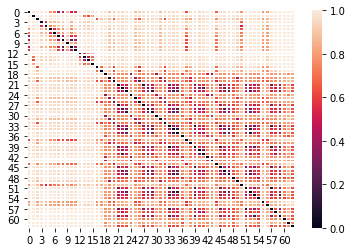

In [54]:
import seaborn as sns
ax = sns.heatmap(matrix, linewidth=0.5)#, xticklabels=cols[:-7], yticklabels=cols[:-7])
#ax.set_xticks(np.arange(len(cols[:-7])))
#ax.set_yticks(np.arange(len(cols[:-7])))
#ax.set_xticklabels(cols[:-7])
#ax.set_yticklabels(cols[:-7])
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")
plt.show()